# NGO ROI(ROAS) 예측모델

## 목차
1. 회귀분석주제 소개 및 분석 로드맵
2. NGO기관 'S'기관의 후원광고 실적 분석
3. 회귀분석 모델개발
    1. 기준모델 : 단일선형회귀(Audiece-InboundCalls)
    2. 광고량으로 인바운드콜 예측하는 모델
    3. 예측된 인바운드콜으로 후원건수 예측하는 모델
4. 회귀모델 예측값으로 광고예산 대비 예상ROI, 예상후원금 Curve
5. 향후 개선사항 및 과제

In [14]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


import xlsxwriter
import openpyxl
import pandas as pd
from matplotlib import rc
import matplotlib as mpl
import matplotlib.pyplot as plt

rc('font', family='Malgun Gothic')

import seaborn as sns

from PIL import Image
import PIL.Image as pilimg

## 1. 회귀분석주제 소개 및 분석 로드맵

#### NGO 후원예측에 대한 소개

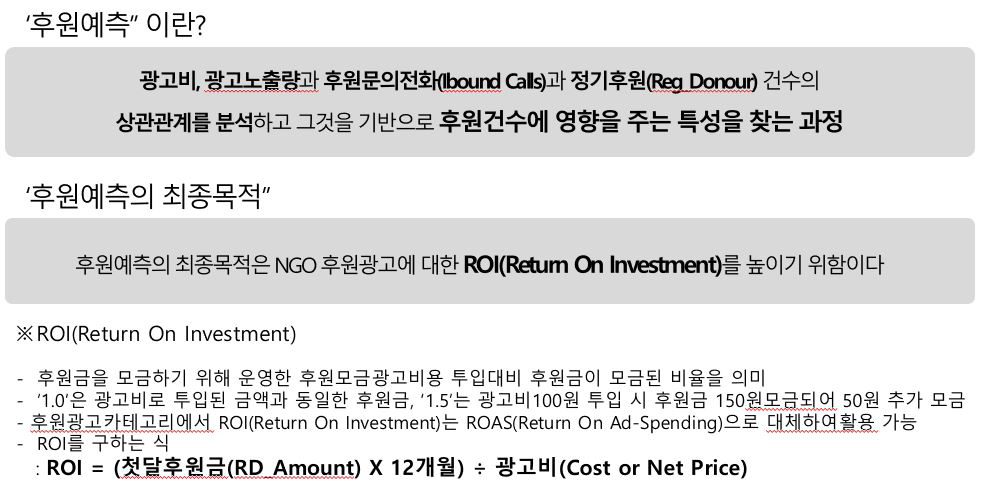

In [15]:
im_01 = pilimg.open("./Imgs/ngo_01.jpg")
im_01

#### 후원예측 분석 로드맵

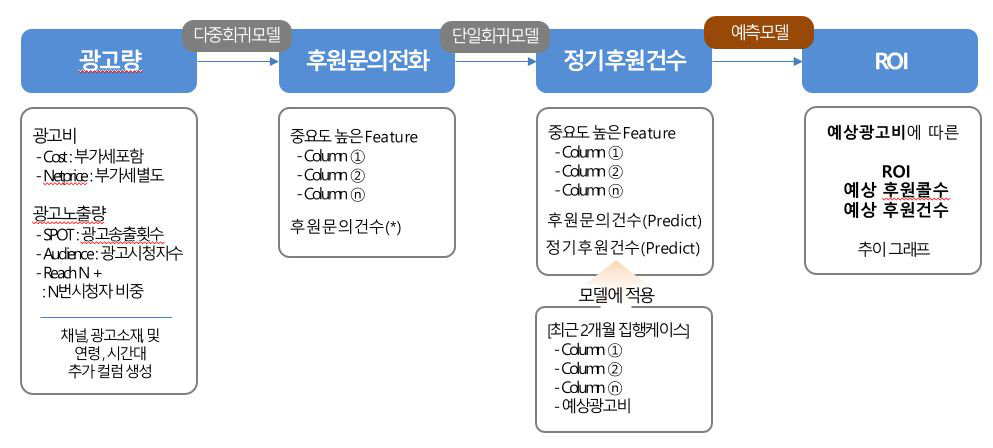

In [18]:
im_02 = pilimg.open("./Imgs/ngo_02.jpg")
im_02

## 2. NGO기관 'S'기관의 후원광고 실적분석

In [19]:
# 데이터불러오기

In [23]:
df_result = pd.read_excel("./Datas/df_result_merged.xlsx")
df_result.dtypes
df_result = df_result.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df_result = df_result.rename({'Net Price':'Net_Price',
                              'Date_x':'Date',
                              'Daypart_x':'Daypart',
                              'Channel_x':'Channel',
                              'Creative_x':'Creative',
                              'I/B콜수':'Inbound_Calls',
                              '정기후원':'Reg_Donour',
                              '후원금액':'RD_Amount'}, axis='columns')
df_result['Audience'] = df_result.Audience.astype('int64')
df_result['Net_Price'] = df_result.Net_Price.astype('int64')

In [24]:
# 날짜변환하여 컬럼으로 반영하기

In [25]:
import datetime, time
df_result['Year'] = df_result['Date'].dt.year
df_result['Month'] = df_result['Date'].dt.month
df_result['Week'] = df_result['Date'].dt.weekofyear
df_result['Day'] = df_result['Date'].dt.day
df_result['Dayofweek'] = df_result['Date'].dt.weekday

#### 후원광고 실적분석[최근 12개월 일일 후원실적]

In [32]:
# 일별합산값으로 전환
efbyday_sum = pd.pivot_table(df_result, 
                     index = ['Year', 'Month', 'Day'],
                     values = ['Net_Price','Audience','SPOT','Inbound_Calls','Reg_Donour', 'RD_Amount'],
                     aggfunc = ['sum']
                     )
efby_sum = efbyday_sum.reset_index()
cols = ['Year', 'Month','Day', 'Audience', 'Inbound_Calls', 'Net_Price', 'RD_Amount', 'Reg_Donour', 'SPOT']
efby_sum = pd.DataFrame(efby_sum.values, columns = cols)
efby_sum = efby_sum.astype({
    'Year' : str, 
    'Month': str,
    'Day': str, 
    'Audience' : int, 
    'Inbound_Calls' : int, 
    'Net_Price' : int, 
    'RD_Amount' : int, 
    'Reg_Donour' : int, 
    'SPOT' : int    
})
#col_default = col_default.astype("int")

In [33]:
# 월별 일평균 실적
efbymonth_mean =  pd.pivot_table(efby_sum, 
                     index = ['Year', 'Month'],
                     values = ['Net_Price','Audience','SPOT','Inbound_Calls','Reg_Donour', 'RD_Amount'],
                     aggfunc = ['mean']
                     ).astype('int')

efby_mean = efbymonth_mean.reset_index()
cols = ['Year', 'Month', 'Audience', 'Inbound_Calls', 'Net_Price', 'RD_Amount', 'Reg_Donour', 'SPOT']
efby_mean = pd.DataFrame(efby_mean.values, columns = cols)
efby_mean = efby_mean.astype({
    'Year' : str, 
    'Month': int,
    'Audience' : int, 
    'Inbound_Calls' : int, 
    'Net_Price' : int, 
    'RD_Amount' : int, 
    'Reg_Donour' : int, 
    'SPOT' : int    
})

In [36]:
# 평가지표 컬럼추가


#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_mean['RD_Amount'] = (efby_mean['RD_Amount'] / 1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_mean['CV_R'] = round((efby_mean['Reg_Donour'] / efby_mean['Inbound_Calls'])*100,1)

#Cost : VAT를 포함한 광고비
efby_mean['Cost'] = ((efby_mean['Net_Price']*1.1)/1000).astype(int)

# ROI :  정기후원*12 ÷ 광고비(VAT포함)
efby_mean['ROI'] = round((efby_mean['RD_Amount']*12)/(efby_mean['Cost']), 1)

# CPR : 콜당비용, 단위천원
efby_mean['CPR'] = (efby_mean['Cost']/ efby_mean['Inbound_Calls']).astype('int')

# CPD : 후원건당비용, 단위천원
efby_mean['CPD'] = (efby_mean['Cost']/ efby_mean['Reg_Donour']).astype('int')

# CPM : 1000명당비용, 단위천원
efby_mean['CPM'] = round((efby_mean['Cost']/ efby_mean['Audience']*1000),2)

efby_mean = efby_mean.sort_values(by=['Year','Month'])

efby_mean.tail(12)

# 월별효율데이터
monthly_eff = efby_mean[['Year','Month', 'Inbound_Calls', 'Reg_Donour', 'CV_R', 'Cost', 'RD_Amount', 'ROI', 'CPR', 'CPD', 'CPM']]
monthly_eff = monthly_eff.reset_index(drop=True)

#### --- 특정채널 누락됨 Merge하는 거 신경써야할 듯. 큐시트-송출내역 반영필요

In [35]:
monthly_eff.tail(12)

Year  Month  Inbound_Calls  Reg_Donour  CV_R   Cost  RD_Amount  ROI  CPR  \
24  2020      1             83          23  27.7   7284        517  0.9   87   
25  2020      2            110          39  35.5  10546        885  1.0   95   
26  2020      3             76          24  31.6   8519        541  0.8  112   
27  2020      4             69          24  34.8   7586        514  0.8  109   
28  2020      5             58          19  32.8   7607        439  0.7  131   
29  2020      6             62          21  33.9   7353        469  0.8  118   
30  2020      7             56          20  35.7   6793        434  0.8  121   
31  2020      8             59          17  28.8   5982        391  0.8  101   
32  2020      9             67          22  32.8   7035        505  0.9  105   
33  2020     10             54          18  33.3   8025        396  0.6  148   
34  2020     11             55          18  32.7   8536        403  0.6  155   
35  2020     12             53          15  28.3   6064        326  0.6  114   

    CPD   CPM  
24  316  6.12  
25  270  5.44  
26  354  4.70  
27  316  4.07  
28  400  4.47  
29  350  4.76  
30  339  4.99  
31  351  4.77  
32  319  4.93  
33  445  5.22  
34  474  4.99  
35  404  3.85

```
1) Inbound_Calls : 후원문의전화수, 단위-건
2) Reg Donour : 정기후원수, 단위-건
3) CV_R : 후원전환율, 단위-%
4) Cost : 부가세포함광고비, 단위:천원
5) RD Amount : 첫달정기후원금액, 단위-천원
6) ROI : 광고비대비 정기후원모금비율
7) CPR : 문의전화 1콜 당 비용, 단위-천원
8) CPD : 정깋원 1건 개발 비용, 단위-천원
9) CPM : 시청자 1천명 개발 비용, 단위-천원
```

#### 후원광고 실적분석[요일별 시청자수, 문의전화건수, ROI]

In [37]:
# 일별합산값으로 전환
efbyday_sum = pd.pivot_table(df_result, 
                     index = ['Year', 'Month', 'Dayofweek'],
                     values = ['Net_Price','Audience','SPOT','Inbound_Calls','Reg_Donour', 'RD_Amount'],
                     aggfunc = ['sum']
                     )
efby_sum = efbyday_sum.reset_index()
cols = ['Year', 'Month','Dayofweek', 'Audience', 'Inbound_Calls', 'Net_Price', 'RD_Amount', 'Reg_Donour', 'SPOT']
efby_sum = pd.DataFrame(efby_sum.values, columns = cols)
efby_sum = efby_sum.astype({
    'Year' : str, 
    'Month': int,
    'Dayofweek': str, 
    'Audience' : int, 
    'Inbound_Calls' : int, 
    'Net_Price' : int, 
    'RD_Amount' : int, 
    'Reg_Donour' : int, 
    'SPOT' : int    
})


In [38]:
# 평가지표 컬럼추가

#Cost : VAT를 포함한 광고비
efby_sum['Cost'] = ((efby_sum['Net_Price']*1.1)/1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_sum['RD_Amount'] = (efby_sum['RD_Amount'] / 1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_sum['CV_R'] = round((efby_sum['Reg_Donour'] / efby_sum['Inbound_Calls'])*100,1)

# ROI :  정기후원*12 ÷ 광고비(VAT포함)
efby_sum['ROI'] = round((efby_sum['RD_Amount']*12)/(efby_sum['Cost']), 2)

# CPR : 콜당비용, 단위천원
efby_sum['CPR'] = (efby_sum['Cost']/ efby_sum['Inbound_Calls']).astype('int')

# CPD : 후원건당비용, 단위천원
efby_sum['CPD'] = (efby_sum['Cost']/ efby_sum['Reg_Donour']).astype('int')

# CPM : 1000명당비용, 단위천원
efby_sum['CPM'] = round((efby_sum['Cost']/ efby_sum['Audience']*1000),2)

efby_sum = efby_sum.sort_values(by=['Year','Month','Dayofweek'])

# 월별효율데이터
dow_eff = efby_sum[['Year','Month','Dayofweek', 'Audience', 'SPOT', 'Inbound_Calls', 'Reg_Donour', 'CV_R', 'Cost', 'RD_Amount', 'ROI', 'CPR', 'CPD', 'CPM']]
dow_eff = dow_eff.reset_index(drop=True)

In [40]:
# 연도정의
year = '2020'

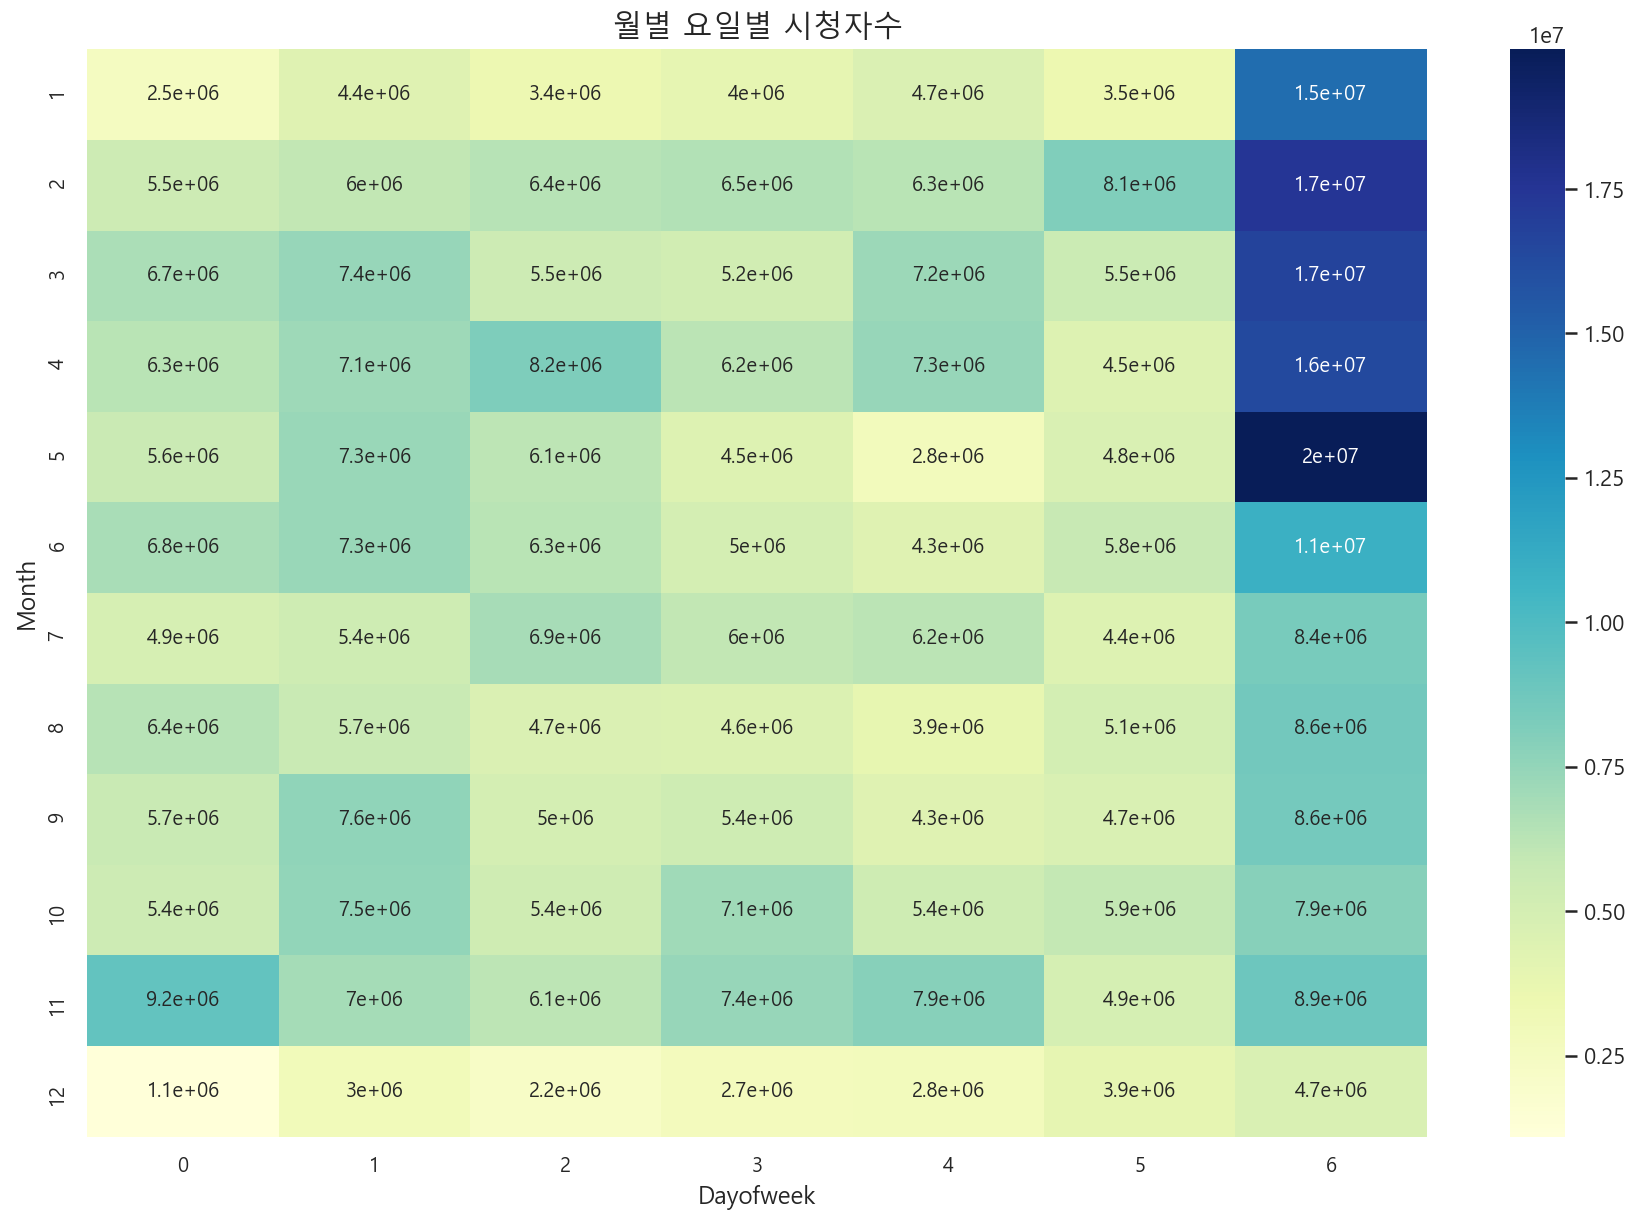

In [45]:
# 요일별 Audience
df_aud = dow_eff[["Year", "Month", "Dayofweek", "Audience"]]
df_aud = df_aud[df_aud["Year"]==year]
df_aud = df_aud.pivot("Month", "Dayofweek", "Audience")

plt.figure(figsize=(15,10))
plt.title("월별 요일별 시청자수", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_aud, cmap="YlGnBu", annot=True)
plt.show()

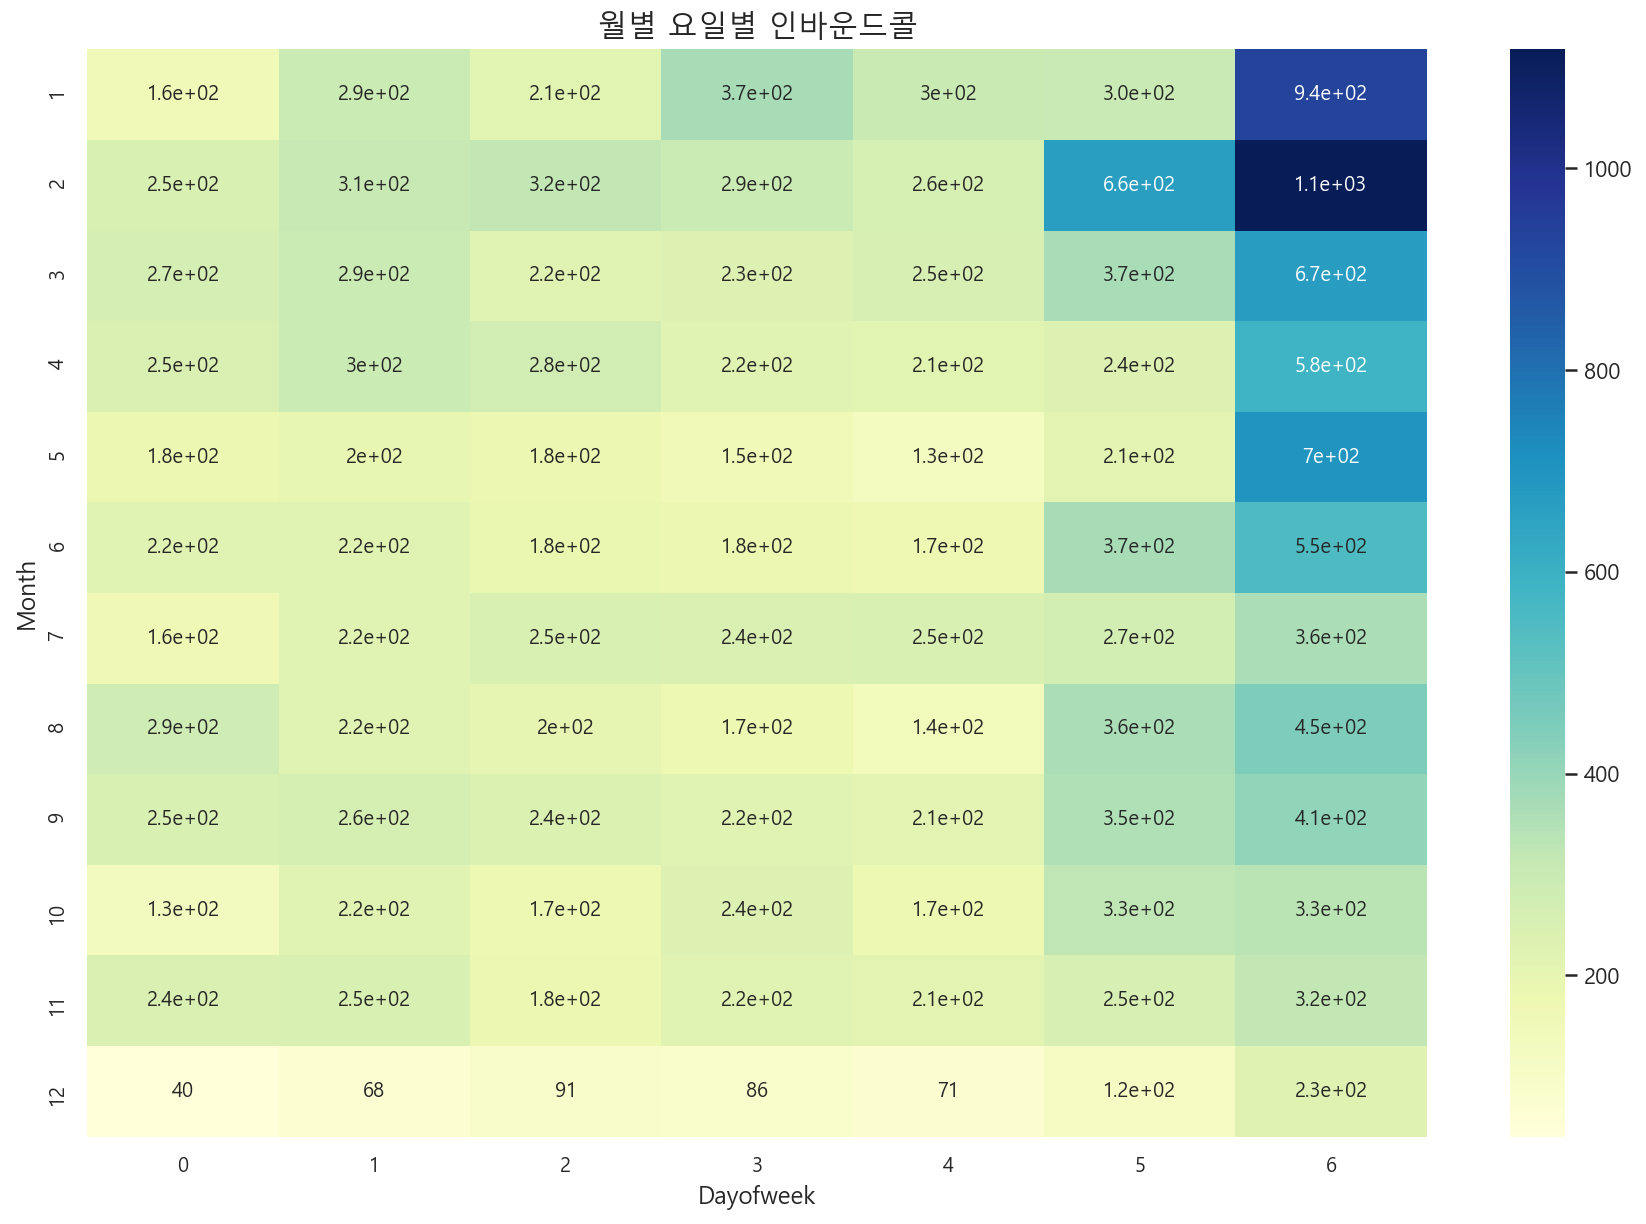

In [47]:
# 요일별 인바운드콜
df_ibc = dow_eff[["Year", "Month", "Dayofweek", "Inbound_Calls"]]
df_ibc = df_ibc[df_ibc["Year"]==year]
df_ibc = df_ibc.pivot("Month", "Dayofweek", "Inbound_Calls")

plt.figure(figsize=(15,10))
plt.title("월별 요일별 인바운드콜", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_ibc, cmap="YlGnBu", annot=True)
plt.show()

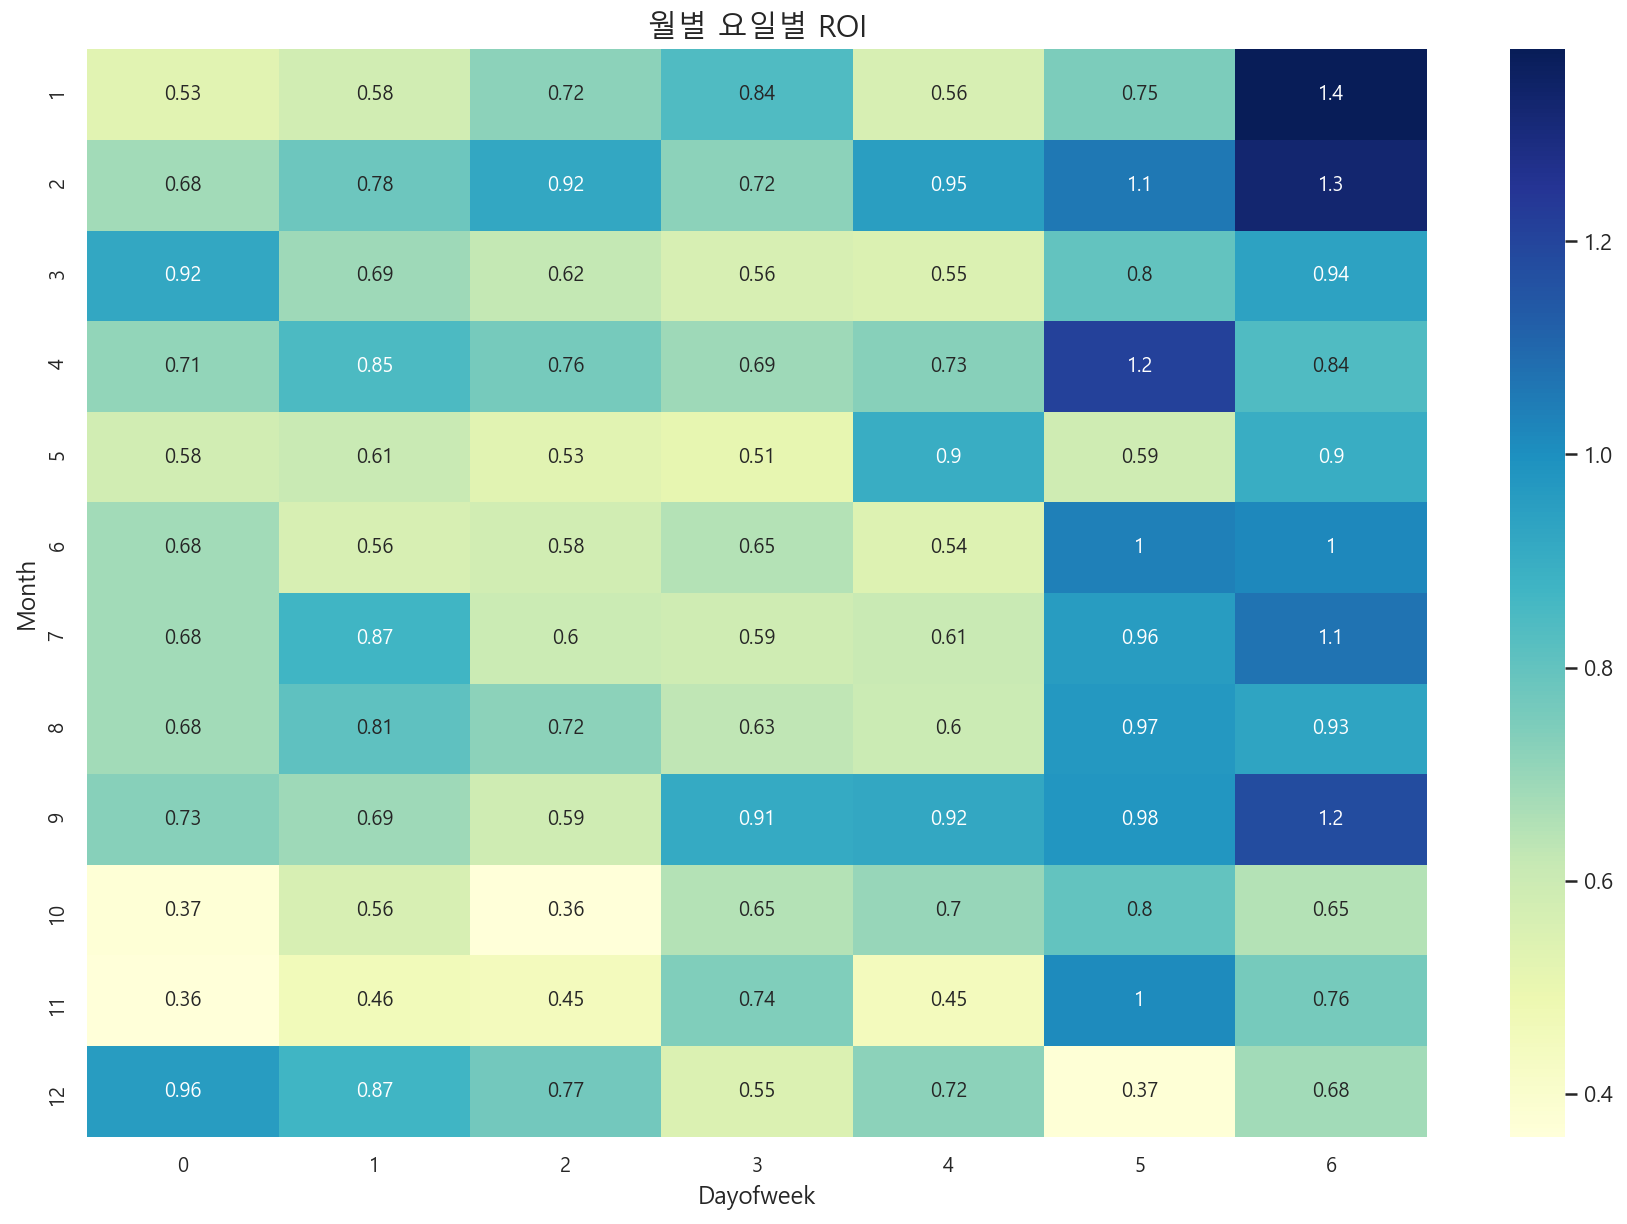

In [49]:
# 요일별 ROI

df_roi = dow_eff[["Year", "Month", "Dayofweek", "ROI"]]
df_roi = df_roi[df_roi["Year"]== year]
df_roi = df_roi.pivot("Month", "Dayofweek", "ROI")

plt.figure(figsize=(15,10))
plt.title("월별 요일별 ROI", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_roi, cmap="YlGnBu", annot=True)
plt.show()

#### 후원광고 실적분석[시간대별 시청자수, 문의전화건수, ROI]

In [61]:
efbyday_sum = pd.pivot_table(df_result, 
                     index = ['Year', 'Month', 'Daypart'],
                     values = ['Net_Price','Audience','SPOT','Inbound_Calls','Reg_Donour', 'RD_Amount'],
                     aggfunc = ['sum']
                     )
efby_sum = efbyday_sum.reset_index()
cols = ['Year', 'Month','Daypart', 'Audience', 'Inbound_Calls', 'Net_Price', 'RD_Amount', 'Reg_Donour', 'SPOT']
efby_sum = pd.DataFrame(efby_sum.values, columns = cols)
efby_sum = efby_sum.astype({
    'Year' : str, 
    'Month': int,
    'Daypart': str, 
    'Audience' : int, 
    'Inbound_Calls' : int, 
    'Net_Price' : int, 
    'RD_Amount' : int, 
    'Reg_Donour' : int, 
    'SPOT' : int    
})


In [62]:
# 평가지표 컬럼추가

#Cost : VAT를 포함한 광고비
efby_sum['Cost'] = ((efby_sum['Net_Price']*1.1)/1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_sum['RD_Amount'] = (efby_sum['RD_Amount'] / 1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_sum['CV_R'] = round((efby_sum['Reg_Donour'] / efby_sum['Inbound_Calls'])*100,1)

# ROI :  정기후원*12 ÷ 광고비(VAT포함)
efby_sum['ROI'] = round((efby_sum['RD_Amount']*12)/(efby_sum['Cost']), 2)

# CPR : 콜당비용, 단위천원
efby_sum['CPR'] = (efby_sum['Cost']/ efby_sum['Inbound_Calls']).astype('int')

# CPD : 후원건당비용, 단위천원
#efby_sum['CPD'] = (efby_sum['Cost']/ efby_sum['Reg_Donour']).astype('int')

# CPM : 1000명당비용, 단위천원
efby_sum['CPM'] = round((efby_sum['Cost']/ efby_sum['Audience']*1000),2)

efby_sum = efby_sum.sort_values(by=['Year','Month','Daypart'])

# 월별효율데이터
dp_eff = efby_sum[['Year','Month','Daypart', 'Audience', 'SPOT', 'Inbound_Calls', 'Reg_Donour', 'CV_R', 'Cost', 'RD_Amount', 'ROI', 'CPR', 'CPM']]
dp_eff = dp_eff.reset_index(drop=True)

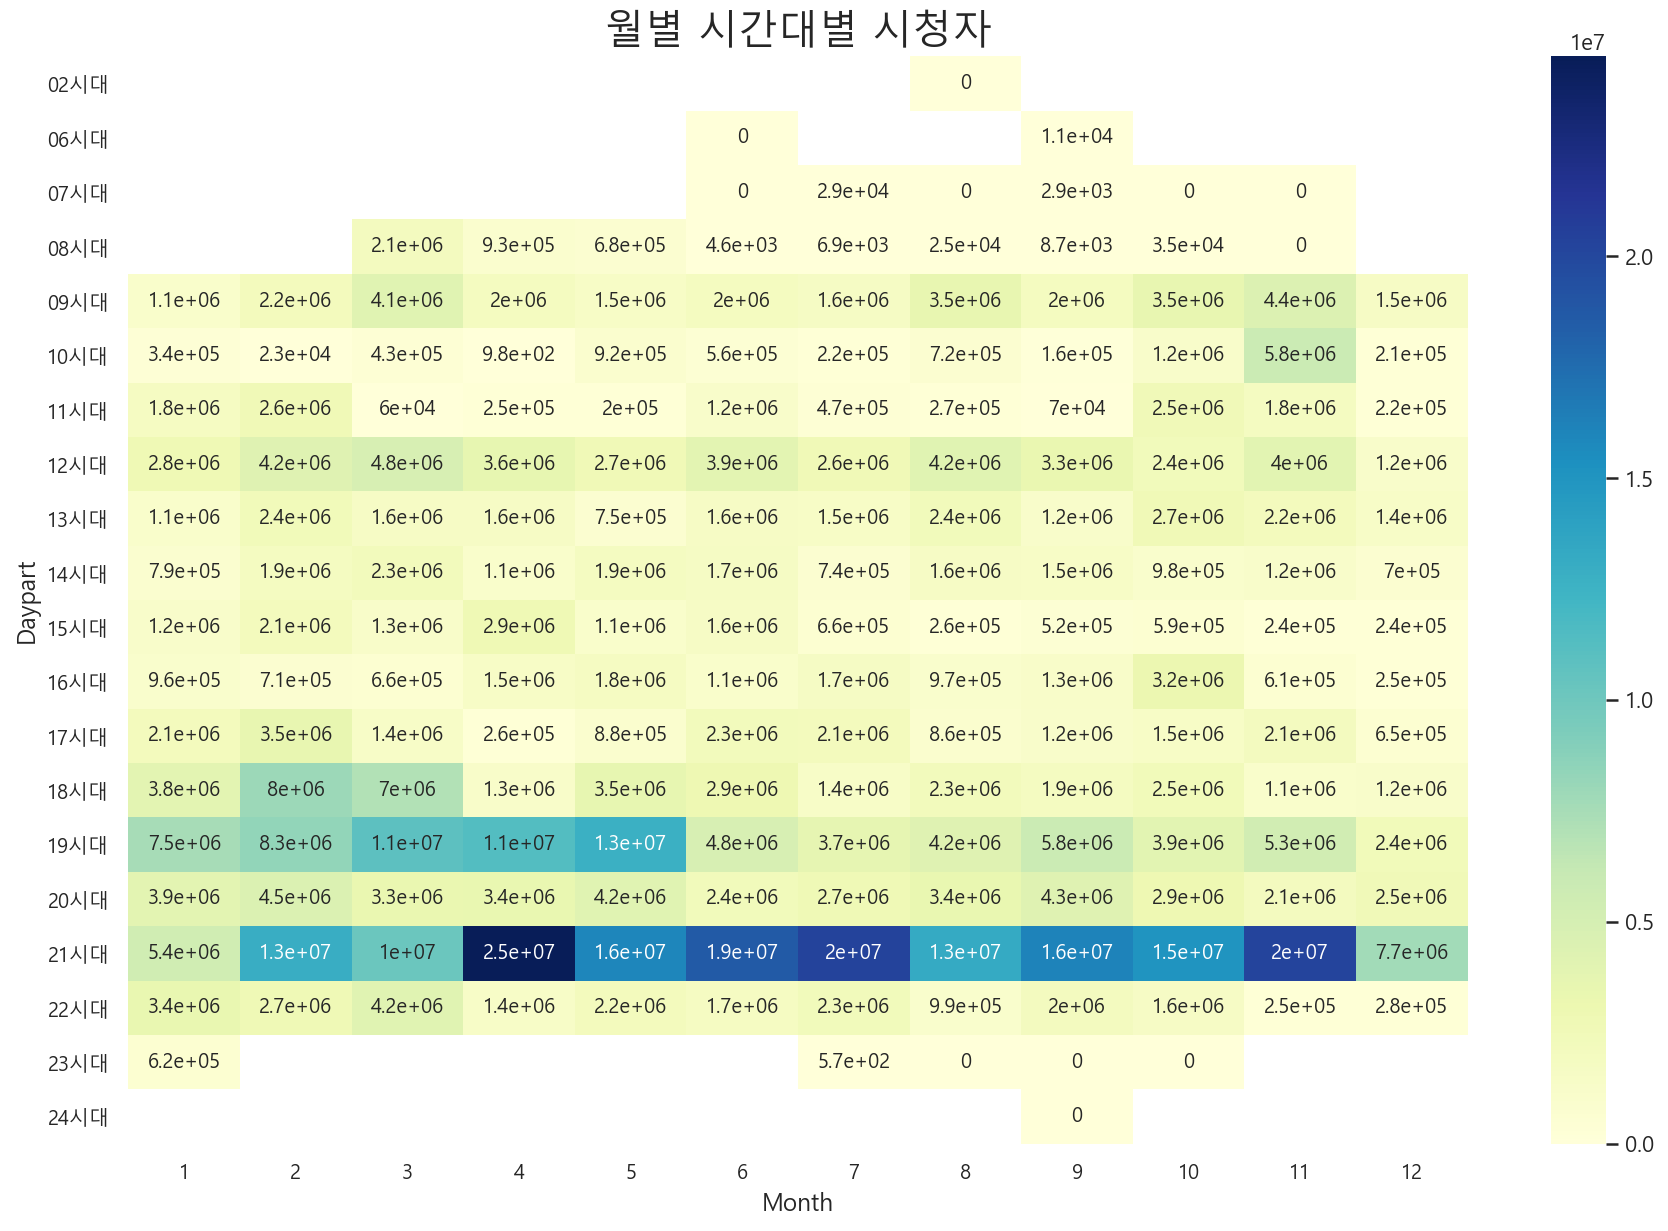

In [63]:
# 시간대별 Audience
df_aud = dp_eff[["Year", "Month", "Daypart", "Audience"]]
df_aud = df_aud[df_aud["Year"]==year]
df_aud = df_aud.pivot("Daypart", "Month", "Audience")

plt.figure(figsize=(15,10))
plt.title("월별 시간대별 시청자", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_aud, cmap="YlGnBu", annot=True)
plt.show()

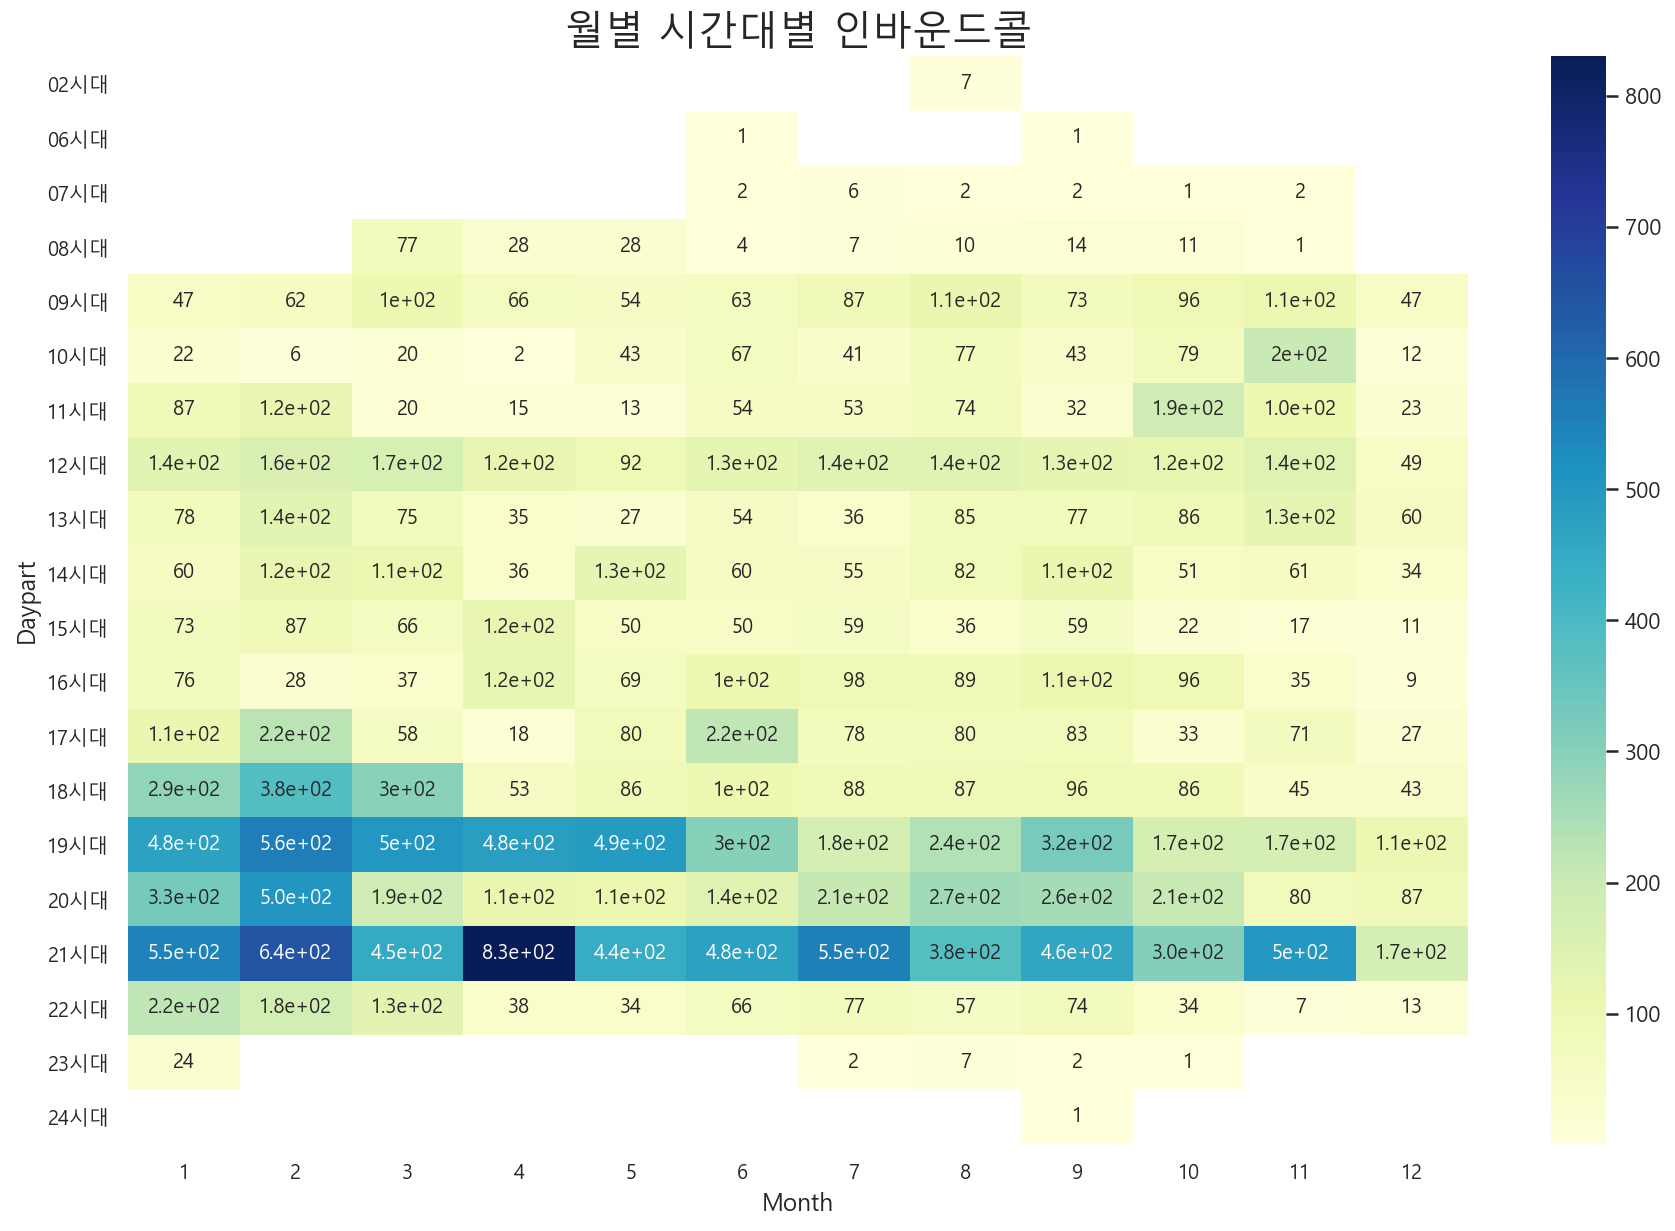

In [64]:
# 시간대별 인바운드콜
df_ibc = dp_eff[["Year", "Month", "Daypart", "Inbound_Calls"]]
df_ibc = df_ibc[df_ibc["Year"]==year]
df_ibc = df_ibc.pivot("Daypart", "Month", "Inbound_Calls")

plt.figure(figsize=(15,10))
plt.title("월별 시간대별 인바운드콜", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_ibc, cmap="YlGnBu", annot=True)
plt.show()

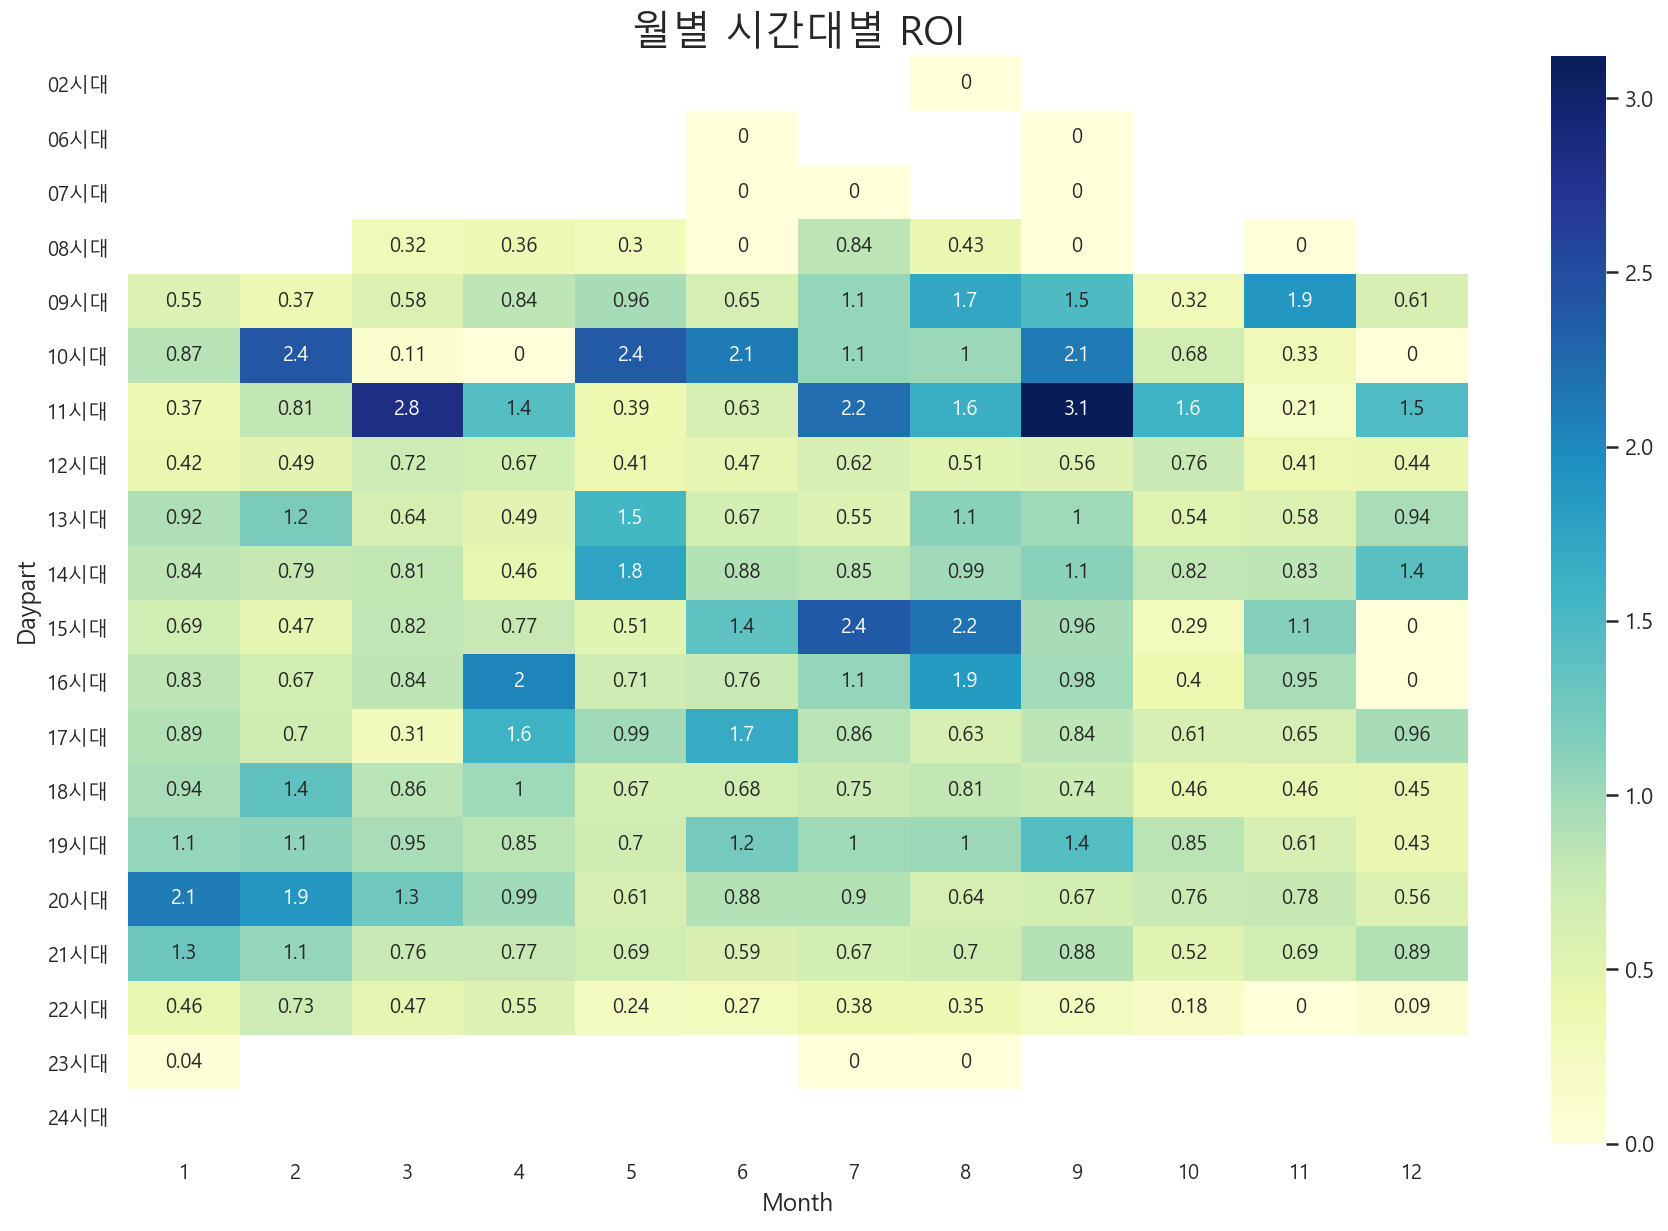

In [65]:
# 시간대별 ROI

df_roi = dp_eff[["Year", "Month", "Daypart", "ROI"]]
df_roi = df_roi[df_roi["Year"]== year]
df_roi = df_roi.pivot("Daypart","Month", "ROI")

plt.figure(figsize=(15,10))
plt.title("월별 시간대별 ROI", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_roi, cmap="YlGnBu", annot=True)
plt.show()

#### 후원광고 실적분석[크리에이티브-채널간 시청자수, 문의전화건수, ROI]

In [68]:
# 일별합산값으로 전환
efbyday_sum = pd.pivot_table(df_result, 
                     index = ['Year','Channel', 'Material'],
                     values = ['Net_Price','Audience','SPOT','Inbound_Calls','Reg_Donour', 'RD_Amount'],
                     aggfunc = ['sum']
                     )
efby_sum = efbyday_sum.reset_index()
cols = ['Year', 'Channel','Material', 'Audience', 'Inbound_Calls', 'Net_Price', 'RD_Amount', 'Reg_Donour', 'SPOT']
efby_sum = pd.DataFrame(efby_sum.values, columns = cols)
efby_sum = efby_sum.astype({
    'Year' : str, 
    'Channel': str,
    'Material' : str,
    'Audience' : int, 
    'Inbound_Calls' : int, 
    'Net_Price' : int, 
    'RD_Amount' : int, 
    'Reg_Donour' : int, 
    'SPOT' : int    
})


In [69]:
# 평가지표 컬럼추가

#Cost : VAT를 포함한 광고비
efby_sum['Cost'] = ((efby_sum['Net_Price']*1.1)/1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_sum['RD_Amount'] = (efby_sum['RD_Amount'] / 1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_sum['CV_R'] = round((efby_sum['Reg_Donour'] / efby_sum['Inbound_Calls'])*100,1)

# ROI :  정기후원*12 ÷ 광고비(VAT포함)
efby_sum['ROI'] = round((efby_sum['RD_Amount']*12)/(efby_sum['Cost']), 2)

# CPR : 콜당비용, 단위천원
efby_sum['CPR'] = (efby_sum['Cost']/ efby_sum['Inbound_Calls']).astype('int')

# CPD : 후원건당비용, 단위천원
#efby_sum['CPD'] = (efby_sum['Cost']/ efby_sum['Reg_Donour']).astype('int')

# CPM : 1000명당비용, 단위천원
efby_sum['CPM'] = round((efby_sum['Cost']/ efby_sum['Audience']*1000),2)

efby_sum = efby_sum.sort_values(by=['Year'])

# 월별효율데이터
ch_eff = efby_sum[['Year','Channel','Material', 'Audience', 'SPOT', 'Inbound_Calls', 'Reg_Donour', 'CV_R', 'Cost', 'RD_Amount', 'ROI', 'CPR', 'CPM']]
ch_eff = ch_eff.reset_index(drop=True)
ch_eff = ch_eff.fillna(0)

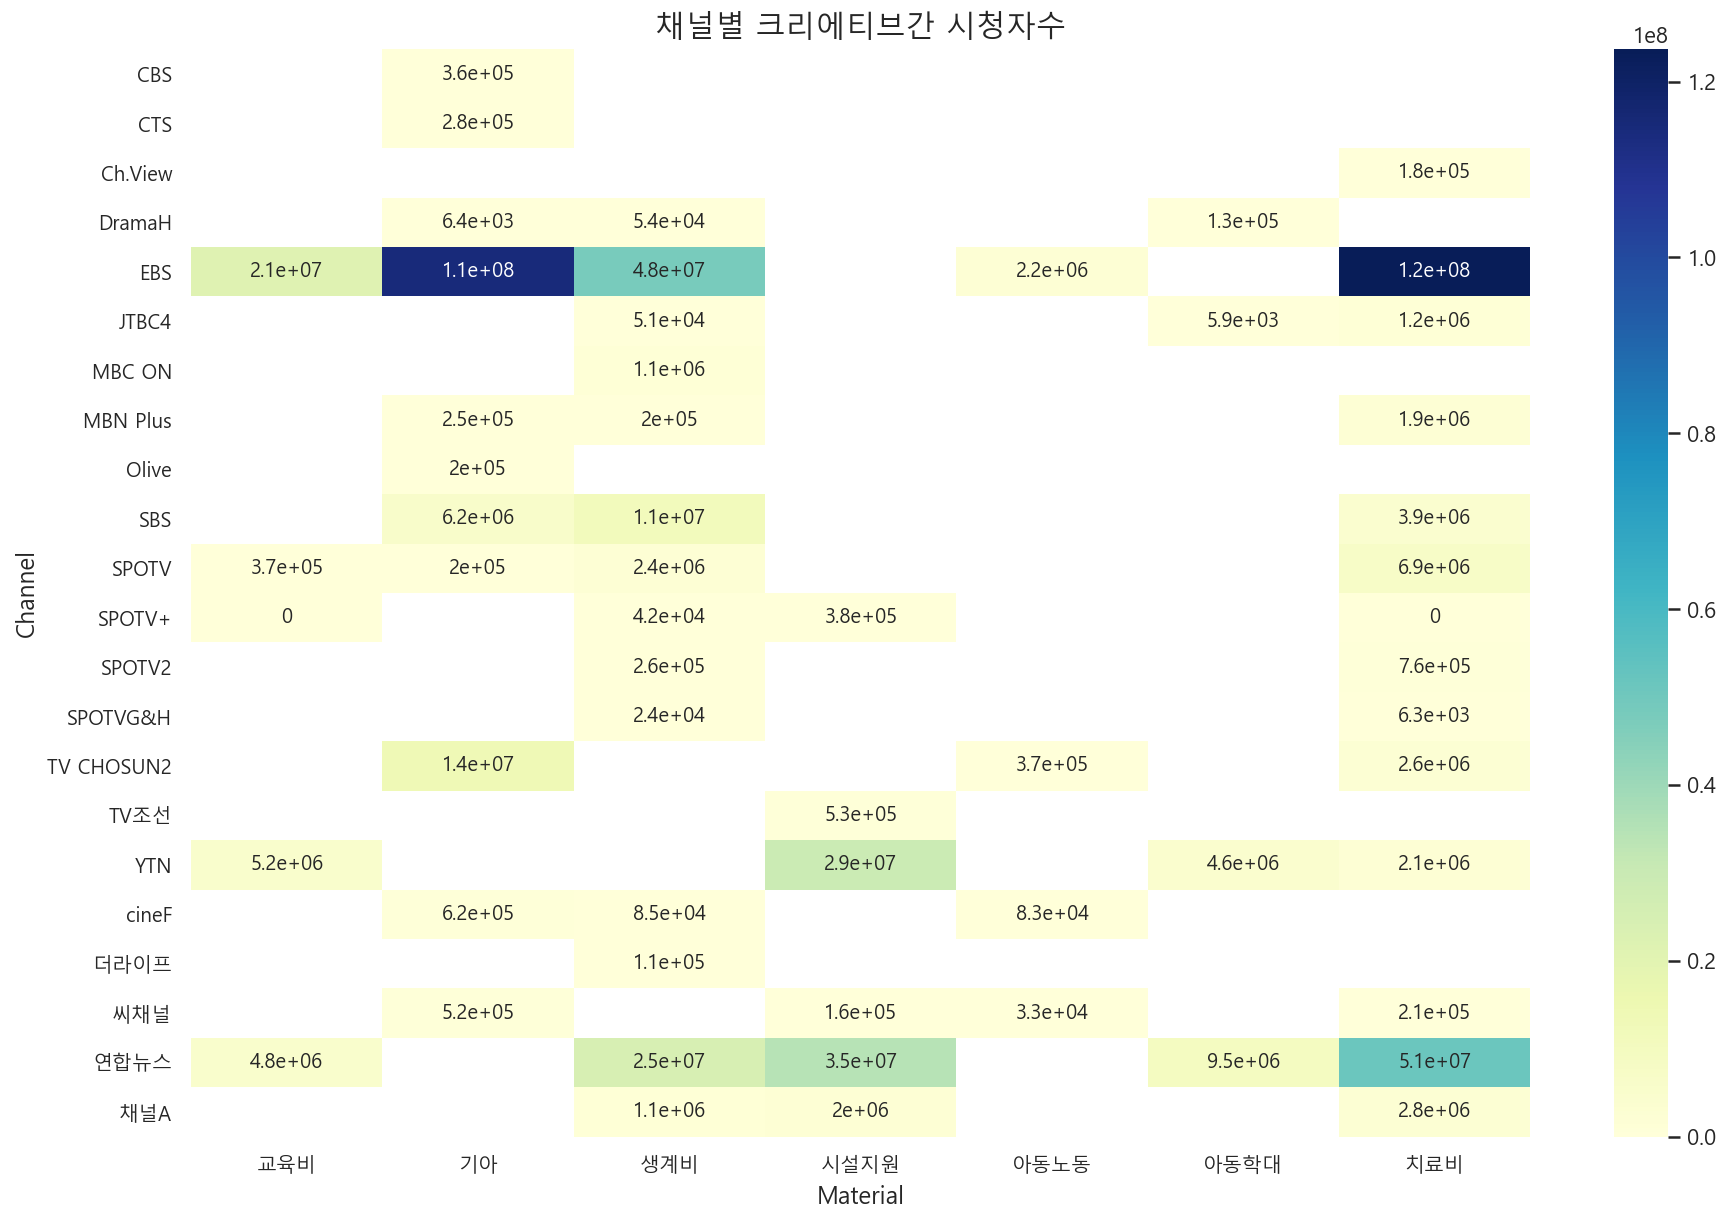

In [71]:
# 크리에이티브별 ROI

df_roi = ch_eff[["Year","Channel","Material", "Audience"]]
df_roi = df_roi[df_roi["Year"]==year]
df_roi = df_roi.pivot("Channel","Material","Audience")

plt.figure(figsize=(15,10))
plt.title("채널별 크리에티브간 시청자수", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_roi, cmap="YlGnBu", annot=True)
plt.show()

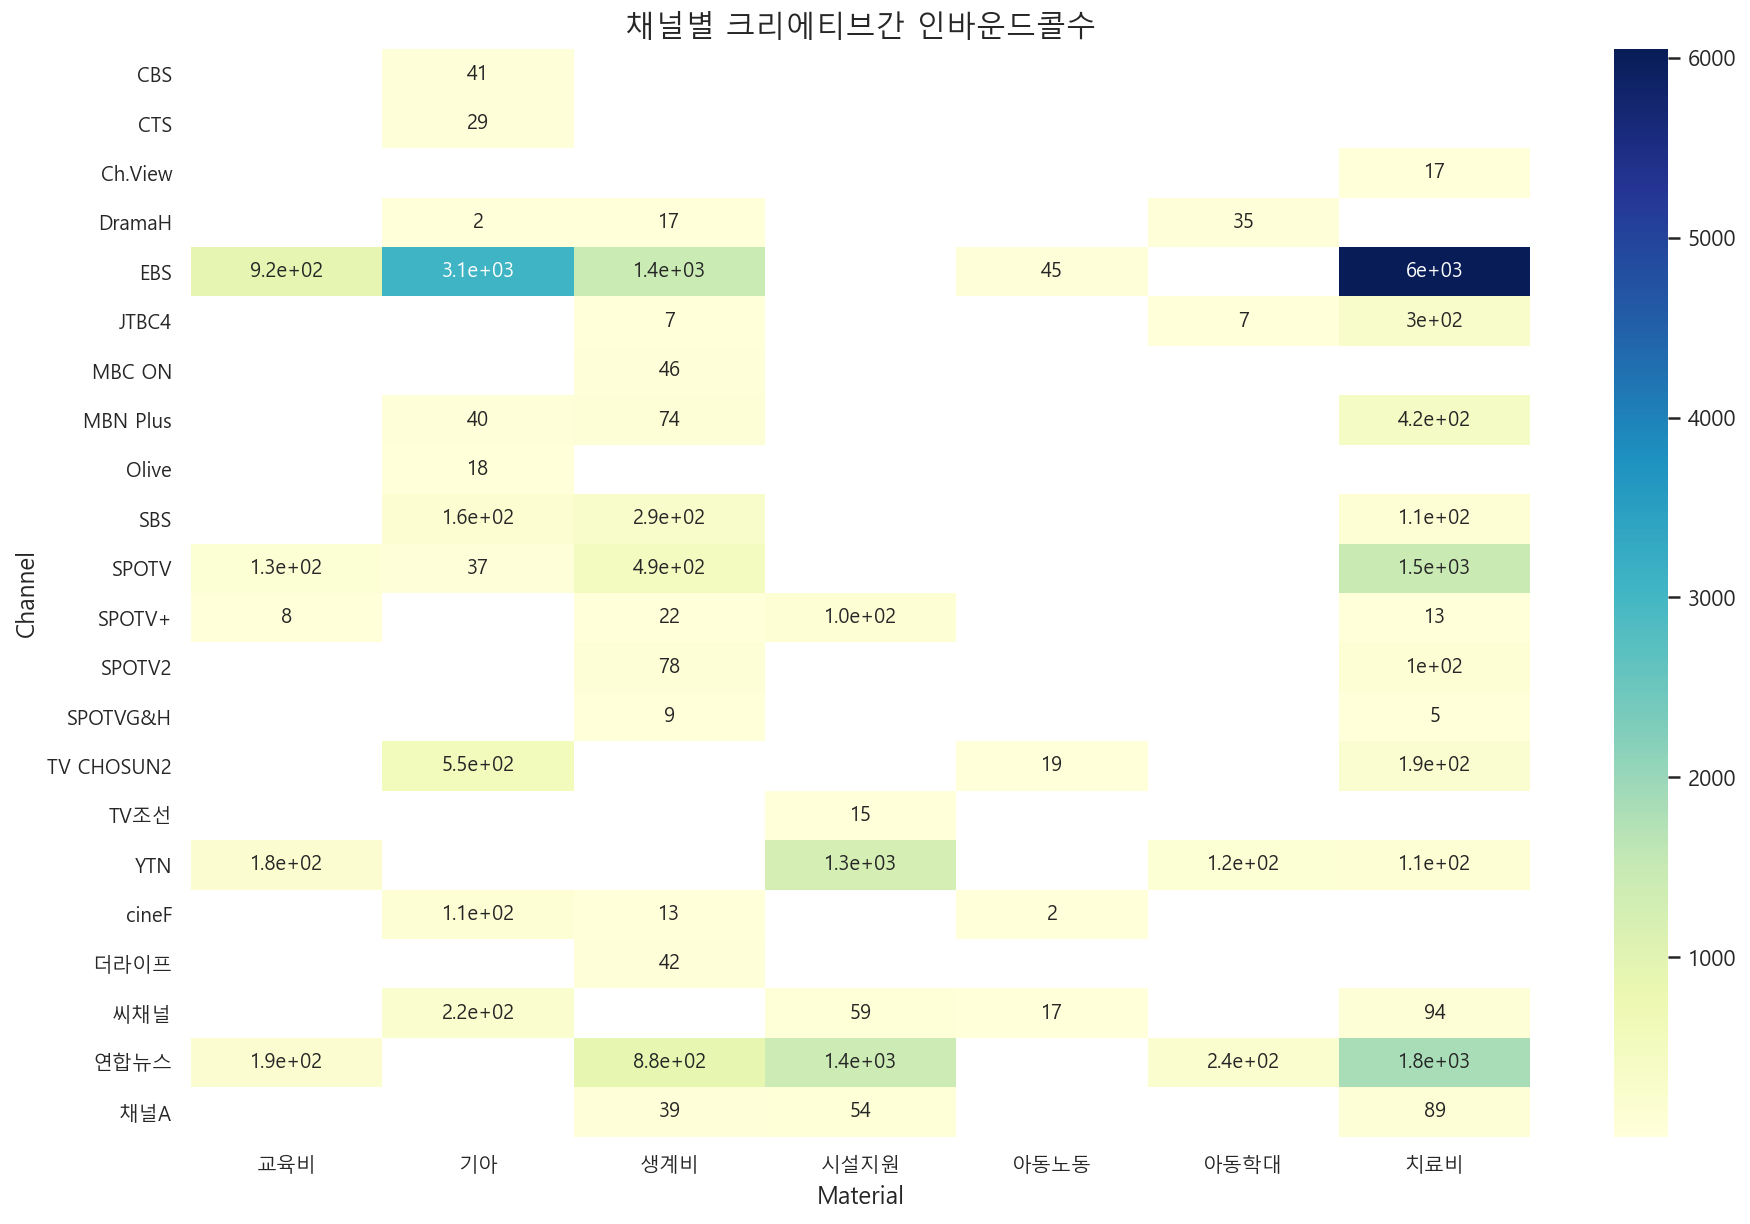

In [72]:
# 크리에이티브별 ROI

df_roi = ch_eff[["Year","Channel","Material", "Inbound_Calls"]]
df_roi = df_roi[df_roi["Year"]==year]
df_roi = df_roi.pivot("Channel","Material","Inbound_Calls")

plt.figure(figsize=(15,10))
plt.title("채널별 크리에티브간 인바운드콜수", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_roi, cmap="YlGnBu", annot=True)
plt.show()

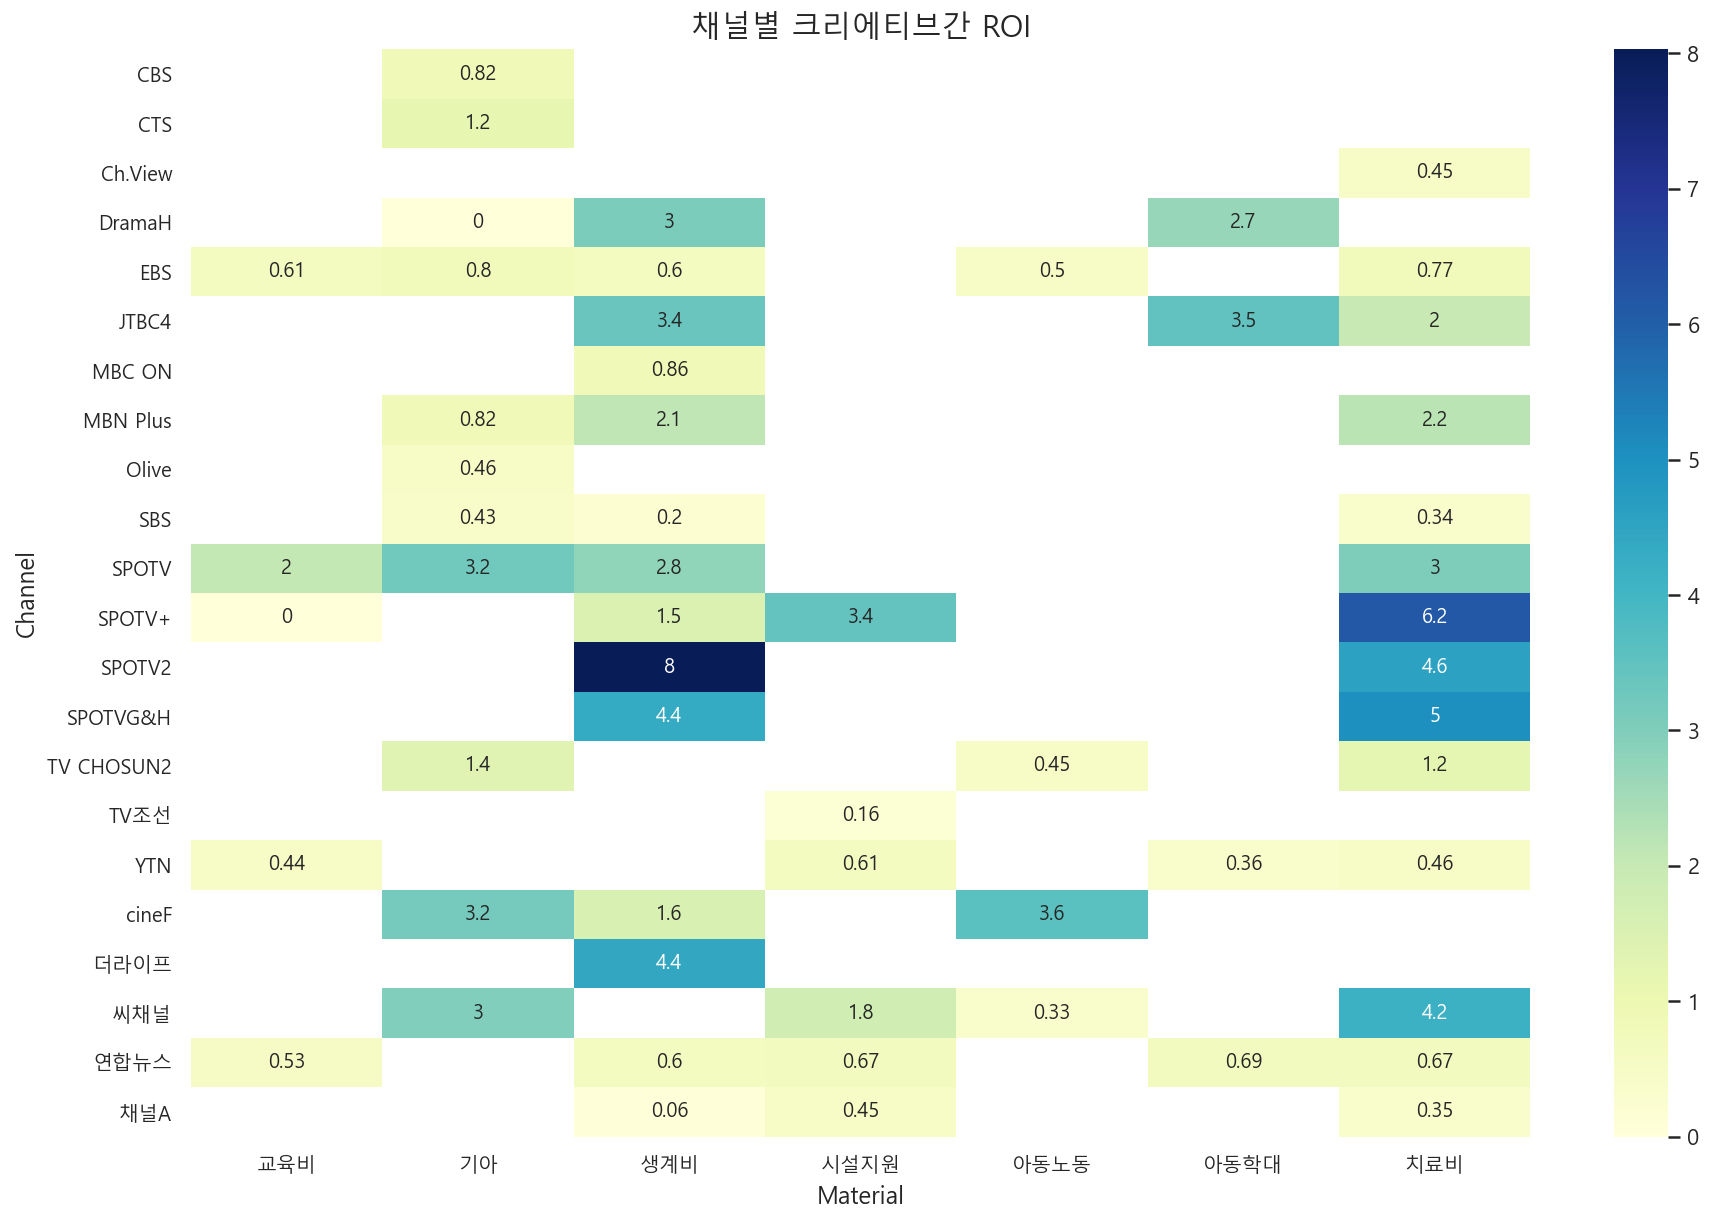

In [73]:
# 크리에이티브별 ROI

df_roi = ch_eff[["Year","Channel","Material", "ROI"]]
df_roi = df_roi[df_roi["Year"]==year]
df_roi = df_roi.pivot("Channel","Material","ROI")

plt.figure(figsize=(15,10))
plt.title("채널별 크리에티브간 ROI", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(df_roi, cmap="YlGnBu", annot=True)
plt.show()

#### 후원광고 실적분석[2020 채널별 인바운드콜]

In [76]:
# 인바운드콜
year = 2020

df_ibc = df_result[["Year","Month","Day","Channel","Inbound_Calls"]]
df_ibc = df_ibc[df_ibc["Year"]==year]
df_ibc['Channel'].unique()

array(['씨채널', 'EBS', 'SPOTV', '채널A', 'SPOTV+', 'YTN', '연합뉴스', 'TV조선',
       'DramaH', 'CTS', 'TV CHOSUN2', 'MBN Plus', 'cineF', 'CBS', 'SBS',
       'JTBC4', 'SPOTV2', 'Ch.View', 'SPOTVG&H', 'Olive', 'MBC ON',
       '더라이프'], dtype=object)

In [77]:
import matplotlib.pyplot as plt

In [78]:
C_ch, EBS, SPOTV, ch_A, SPOTV_plus, YTN, NewsY, TVchosun, DramaH, CTS, TVchosun2, MBN_plus, cineF, CBS, SBS, JTBC4, SPOTV2, chView, SPOTV_gh, Olive, MBCon,theLife = '씨채널', 'EBS', 'SPOTV', '채널A', 'SPOTV+', 'YTN', '연합뉴스', 'TV조선','DramaH', 'CTS', 'TV CHOSUN2', 'MBN Plus', 'cineF', 'CBS', 'SBS','JTBC4', 'SPOTV2', 'Ch.View', 'SPOTVG&H', 'Olive', 'MBC ON','더라이프' 

frame01 = df_ibc.loc[df_ibc['Channel']==C_ch, 'Inbound_Calls']
frame01.index.name = C_ch
frame02 = df_ibc.loc[df_ibc['Channel']==EBS, 'Inbound_Calls']
frame02.index.name = EBS
frame03 = df_ibc.loc[df_ibc['Channel']==SPOTV, 'Inbound_Calls']
frame03.index.name = SPOTV
frame04 = df_ibc.loc[df_ibc['Channel']==ch_A, 'Inbound_Calls']
frame04.index.name = ch_A
frame05 = df_ibc.loc[df_ibc['Channel']==SPOTV_plus, 'Inbound_Calls']
frame05.index.name = SPOTV_plus
frame06 = df_ibc.loc[df_ibc['Channel']==YTN, 'Inbound_Calls']
frame06.index.name = YTN
frame07 = df_ibc.loc[df_ibc['Channel']==NewsY, 'Inbound_Calls']
frame07.index.name = NewsY
frame08 = df_ibc.loc[df_ibc['Channel']==TVchosun, 'Inbound_Calls']
frame08.index.name = TVchosun
frame09 = df_ibc.loc[df_ibc['Channel']==DramaH, 'Inbound_Calls']
frame09.index.name = DramaH
frame10 = df_ibc.loc[df_ibc['Channel']==CTS, 'Inbound_Calls']
frame10.index.name = CTS
frame11 = df_ibc.loc[df_ibc['Channel']==TVchosun2, 'Inbound_Calls']
frame11.index.name = TVchosun2
frame12 = df_ibc.loc[df_ibc['Channel']==MBN_plus, 'Inbound_Calls']
frame12.index.name = MBN_plus
frame13 = df_ibc.loc[df_ibc['Channel']==cineF, 'Inbound_Calls']
frame13.index.name = cineF
frame14 = df_ibc.loc[df_ibc['Channel']==CBS, 'Inbound_Calls']
frame14.index.name = CBS
frame15 = df_ibc.loc[df_ibc['Channel']==SBS, 'Inbound_Calls']
frame15.index.name = SBS
frame16 = df_ibc.loc[df_ibc['Channel']==JTBC4, 'Inbound_Calls']
frame16.index.name = JTBC4
frame17 = df_ibc.loc[df_ibc['Channel']==SPOTV2, 'Inbound_Calls']
frame17.index.name = SPOTV2
frame18 = df_ibc.loc[df_ibc['Channel']==chView, 'Inbound_Calls']
frame18.index.name = chView
frame19 = df_ibc.loc[df_ibc['Channel']==SPOTV_gh, 'Inbound_Calls']
frame19.index.name = SPOTV_gh
frame20 = df_ibc.loc[df_ibc['Channel']==Olive, 'Inbound_Calls']
frame20.index.name = Olive
frame21 = df_ibc.loc[df_ibc['Channel']==MBCon, 'Inbound_Calls']
frame21.index.name = MBCon
frame22 = df_ibc.loc[df_ibc['Channel']==theLife, 'Inbound_Calls']
frame22.index.name = theLife



chartdata1 = [np.array(frame01), 
             np.array(frame02), 
             np.array(frame03), 
             np.array(frame04), 
             np.array(frame05),
             np.array(frame06),
             np.array(frame07), 
             np.array(frame08), 
             np.array(frame09), 
             np.array(frame10),
             np.array(frame11)]

chartdata2 = [np.array(frame12), 
             np.array(frame13), 
             np.array(frame14), 
             np.array(frame15),
             np.array(frame16),
             np.array(frame17), 
             np.array(frame18), 
             np.array(frame19), 
             np.array(frame20),
             np.array(frame21),
             np.array(frame22)]

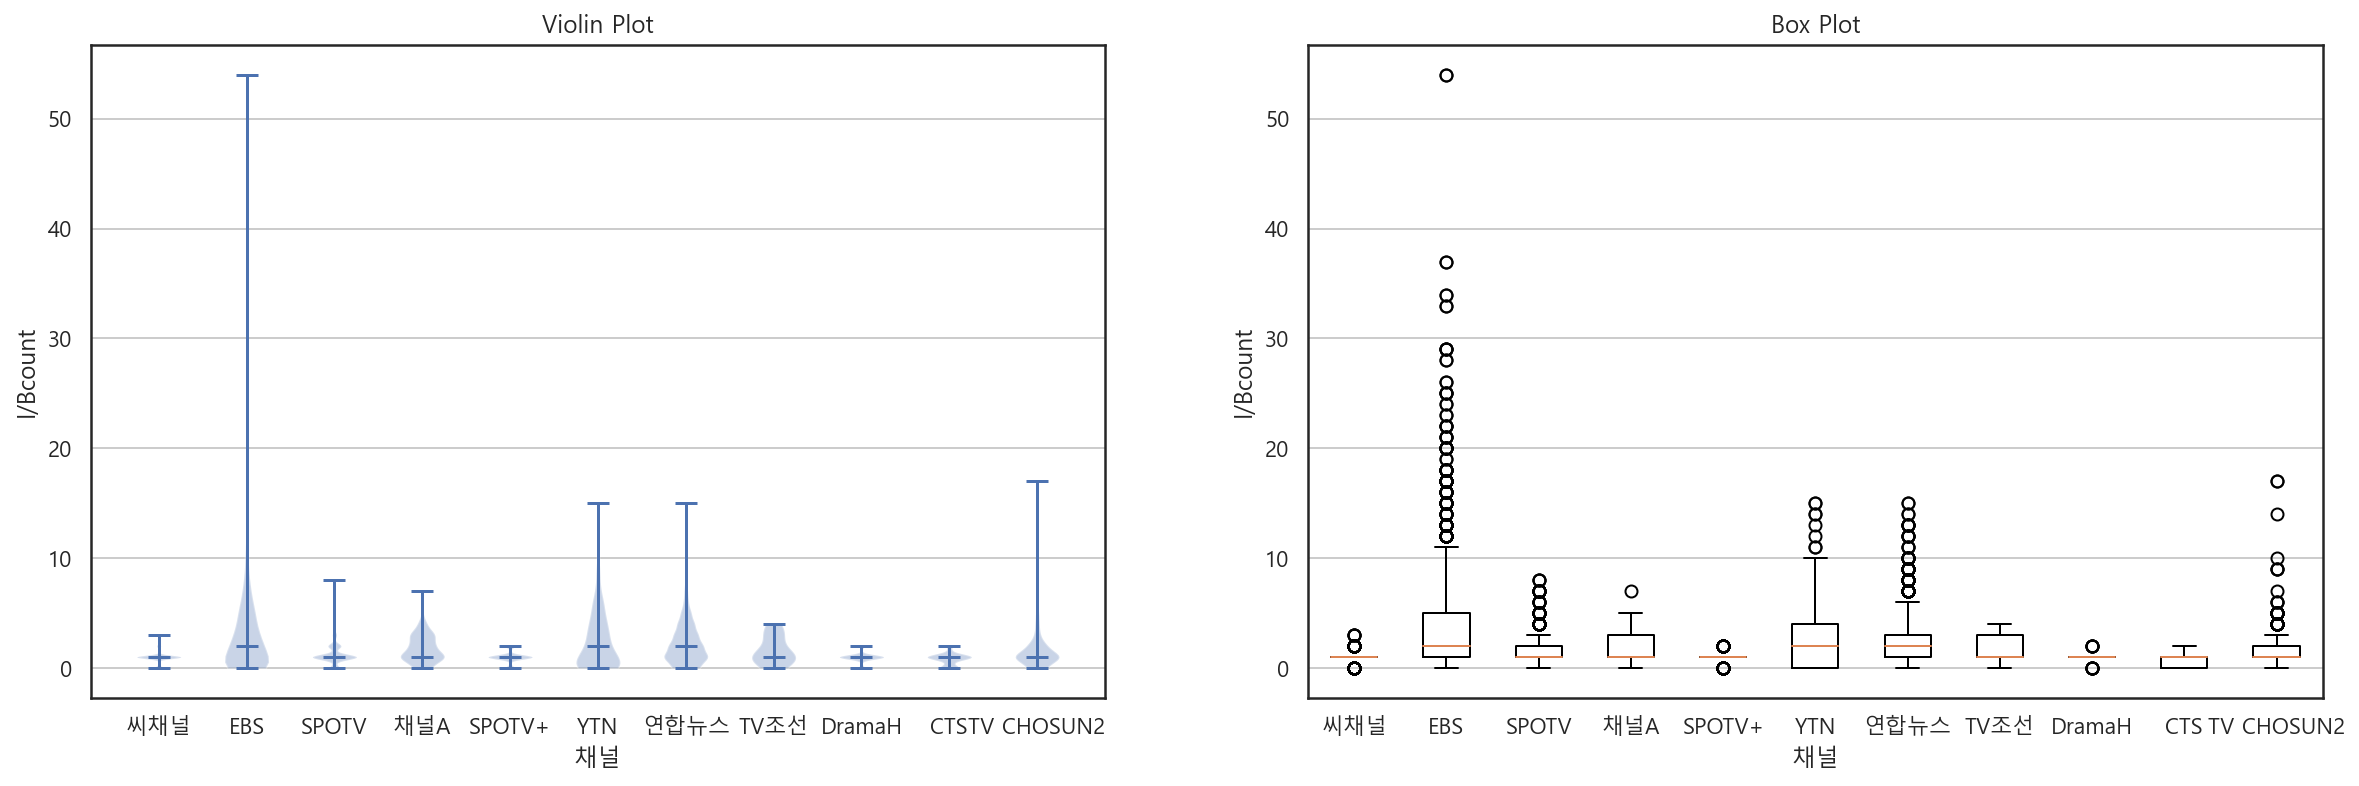

In [79]:
# plot violin plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))


# 박스플롯과 바이올린플롯 그리기
axs[0].violinplot(chartdata1,showmeans=False, showmedians=True)
axs[0].set_title('Violin Plot')

axs[1].boxplot(chartdata1)
axs[1].set_title('Box Plot')

# 수평 Grid 라인 그리기
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(chartdata1))])
    ax.set_xlabel("채널")
    ax.set_ylabel("I/Bcount")
    
# x축에 놓이는 tick지정
plt.setp(axs, xticks=[y + 1 for y in range(len(chartdata1))],xticklabels=[C_ch, EBS, SPOTV, ch_A, SPOTV_plus, YTN, NewsY, TVchosun, DramaH, CTS, TVchosun2])

plt.show()

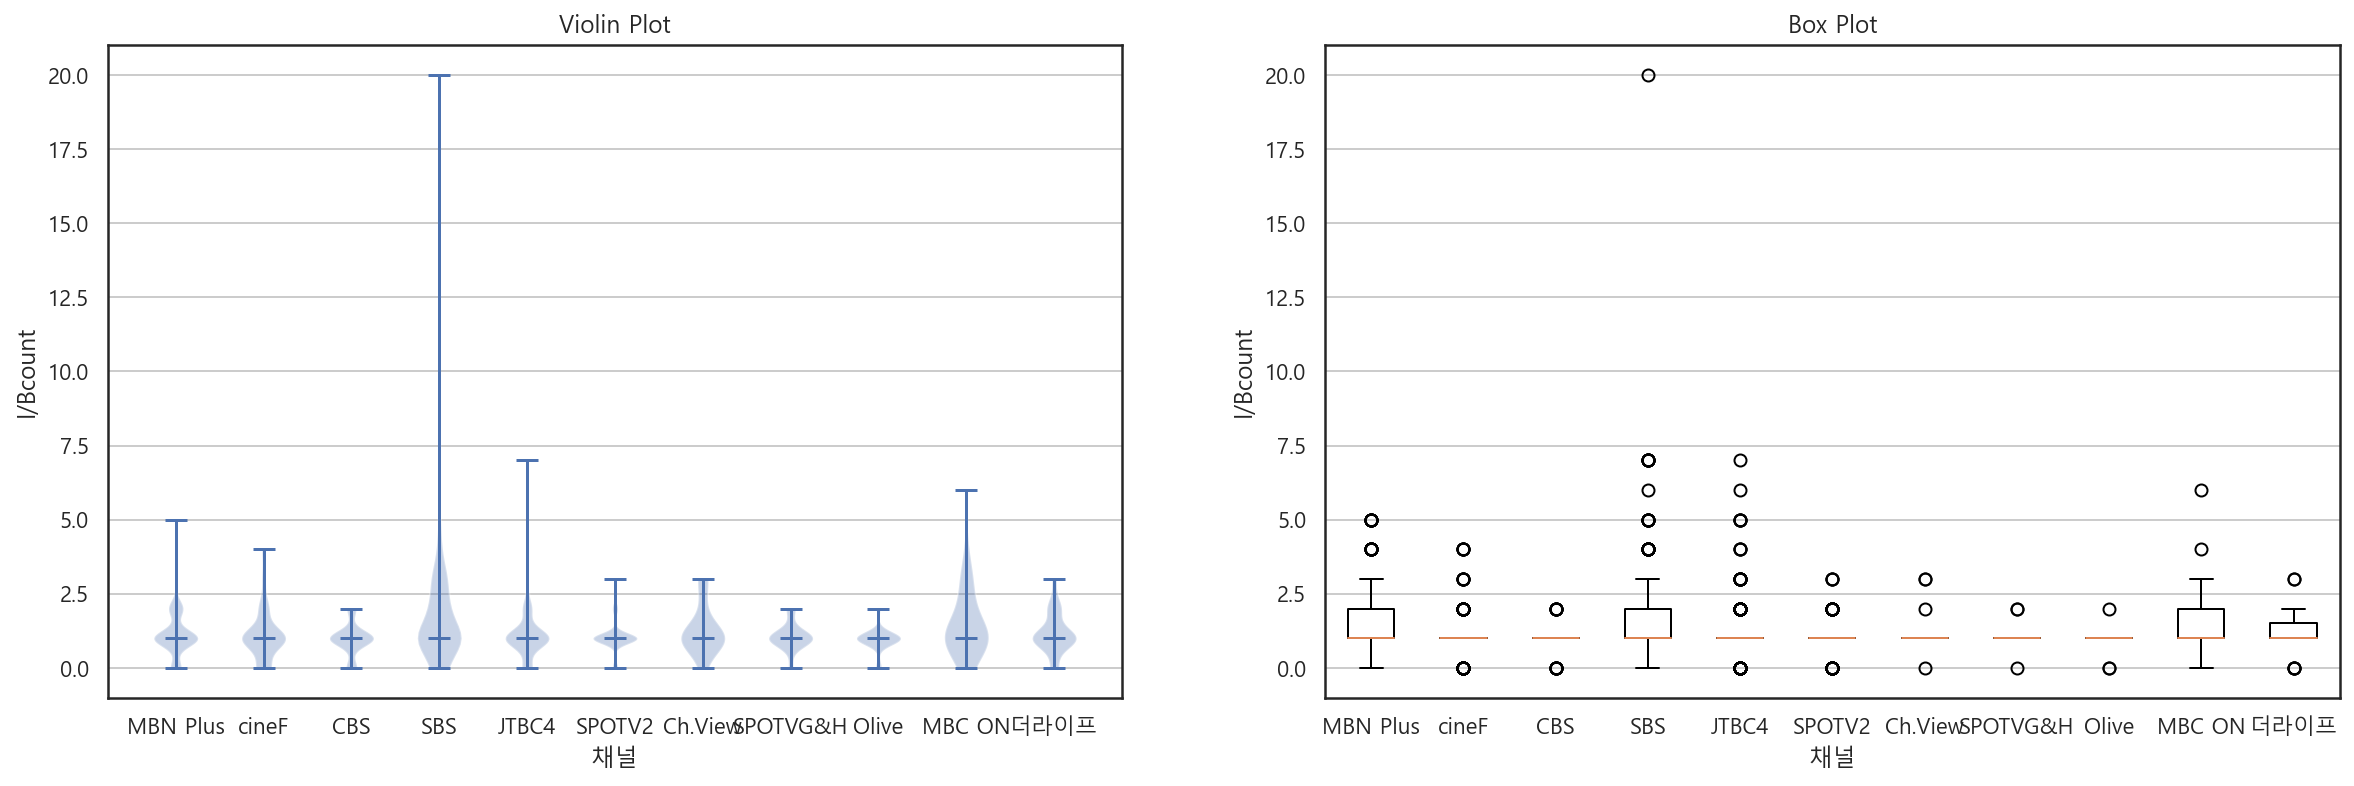

In [80]:
# plot violin plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))


# 박스플롯과 바이올린플롯 그리기
axs[0].violinplot(chartdata2,showmeans=False, showmedians=True)
axs[0].set_title('Violin Plot')

axs[1].boxplot(chartdata2)
axs[1].set_title('Box Plot')

# 수평 Grid 라인 그리기
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(chartdata2))])
    ax.set_xlabel("채널")
    ax.set_ylabel("I/Bcount")
    
# x축에 놓이는 tick지정
plt.setp(axs, xticks=[y + 1 for y in range(len(chartdata2))],xticklabels=[MBN_plus, cineF, CBS, SBS, JTBC4, SPOTV2, chView, SPOTV_gh, Olive, MBCon,theLife])

plt.show()

#### 후원광고 실적분석[2020 채널별 시청자수 콜]

In [82]:
year = 2020

df_aud = df_result[["Year","Month","Day","Channel","Audience"]]
df_aud = df_aud[df_aud["Year"]==year]
df_aud['Channel'].unique()

array(['씨채널', 'EBS', 'SPOTV', '채널A', 'SPOTV+', 'YTN', '연합뉴스', 'TV조선',
       'DramaH', 'CTS', 'TV CHOSUN2', 'MBN Plus', 'cineF', 'CBS', 'SBS',
       'JTBC4', 'SPOTV2', 'Ch.View', 'SPOTVG&H', 'Olive', 'MBC ON',
       '더라이프'], dtype=object)

In [83]:
C_ch, EBS, SPOTV, ch_A, SPOTV_plus, YTN, NewsY, TVchosun, DramaH, CTS, TVchosun2, MBN_plus, cineF, CBS, SBS, JTBC4, SPOTV2, chView, SPOTV_gh, Olive, MBCon,theLife = '씨채널', 'EBS', 'SPOTV', '채널A', 'SPOTV+', 'YTN', '연합뉴스', 'TV조선','DramaH', 'CTS', 'TV CHOSUN2', 'MBN Plus', 'cineF', 'CBS', 'SBS','JTBC4', 'SPOTV2', 'Ch.View', 'SPOTVG&H', 'Olive', 'MBC ON','더라이프' 

frame01 = df_aud.loc[df_aud['Channel']==C_ch, 'Audience']
frame01.index.name = C_ch
frame02 = df_aud.loc[df_aud['Channel']==EBS, 'Audience']
frame02.index.name = EBS
frame03 = df_aud.loc[df_aud['Channel']==SPOTV, 'Audience']
frame03.index.name = SPOTV
frame04 = df_aud.loc[df_aud['Channel']==ch_A, 'Audience']
frame04.index.name = ch_A
frame05 = df_aud.loc[df_aud['Channel']==SPOTV_plus, 'Audience']
frame05.index.name = SPOTV_plus
frame06 = df_aud.loc[df_aud['Channel']==YTN, 'Audience']
frame06.index.name = YTN
frame07 = df_aud.loc[df_aud['Channel']==NewsY, 'Audience']
frame07.index.name = NewsY
frame08 = df_aud.loc[df_aud['Channel']==TVchosun, 'Audience']
frame08.index.name = TVchosun
frame09 = df_aud.loc[df_aud['Channel']==DramaH, 'Audience']
frame09.index.name = DramaH
frame10 = df_aud.loc[df_aud['Channel']==CTS, 'Audience']
frame10.index.name = CTS
frame11 = df_aud.loc[df_aud['Channel']==TVchosun2, 'Audience']
frame11.index.name = TVchosun2
frame12 = df_aud.loc[df_aud['Channel']==MBN_plus, 'Audience']
frame12.index.name = MBN_plus
frame13 = df_aud.loc[df_aud['Channel']==cineF, 'Audience']
frame13.index.name = cineF
frame14 = df_aud.loc[df_aud['Channel']==CBS, 'Audience']
frame14.index.name = CBS
frame15 = df_aud.loc[df_aud['Channel']==SBS, 'Audience']
frame15.index.name = SBS
frame16 = df_aud.loc[df_aud['Channel']==JTBC4, 'Audience']
frame16.index.name = JTBC4
frame17 = df_aud.loc[df_aud['Channel']==SPOTV2, 'Audience']
frame17.index.name = SPOTV2
frame18 = df_aud.loc[df_aud['Channel']==chView, 'Audience']
frame18.index.name = chView
frame19 = df_aud.loc[df_aud['Channel']==SPOTV_gh, 'Audience']
frame19.index.name = SPOTV_gh
frame20 = df_aud.loc[df_aud['Channel']==Olive, 'Audience']
frame20.index.name = Olive
frame21 = df_aud.loc[df_aud['Channel']==MBCon, 'Audience']
frame21.index.name = MBCon
frame22 = df_aud.loc[df_aud['Channel']==theLife, 'Audience']
frame22.index.name = theLife



chartdata1 = [np.array(frame01), 
             np.array(frame02), 
             np.array(frame03), 
             np.array(frame04), 
             np.array(frame05),
             np.array(frame06),
             np.array(frame07), 
             np.array(frame08), 
             np.array(frame09), 
             np.array(frame10),
             np.array(frame11)]

chartdata2 = [np.array(frame12), 
             np.array(frame13), 
             np.array(frame14), 
             np.array(frame15),
             np.array(frame16),
             np.array(frame17), 
             np.array(frame18), 
             np.array(frame19), 
             np.array(frame20),
             np.array(frame21),
             np.array(frame22)]

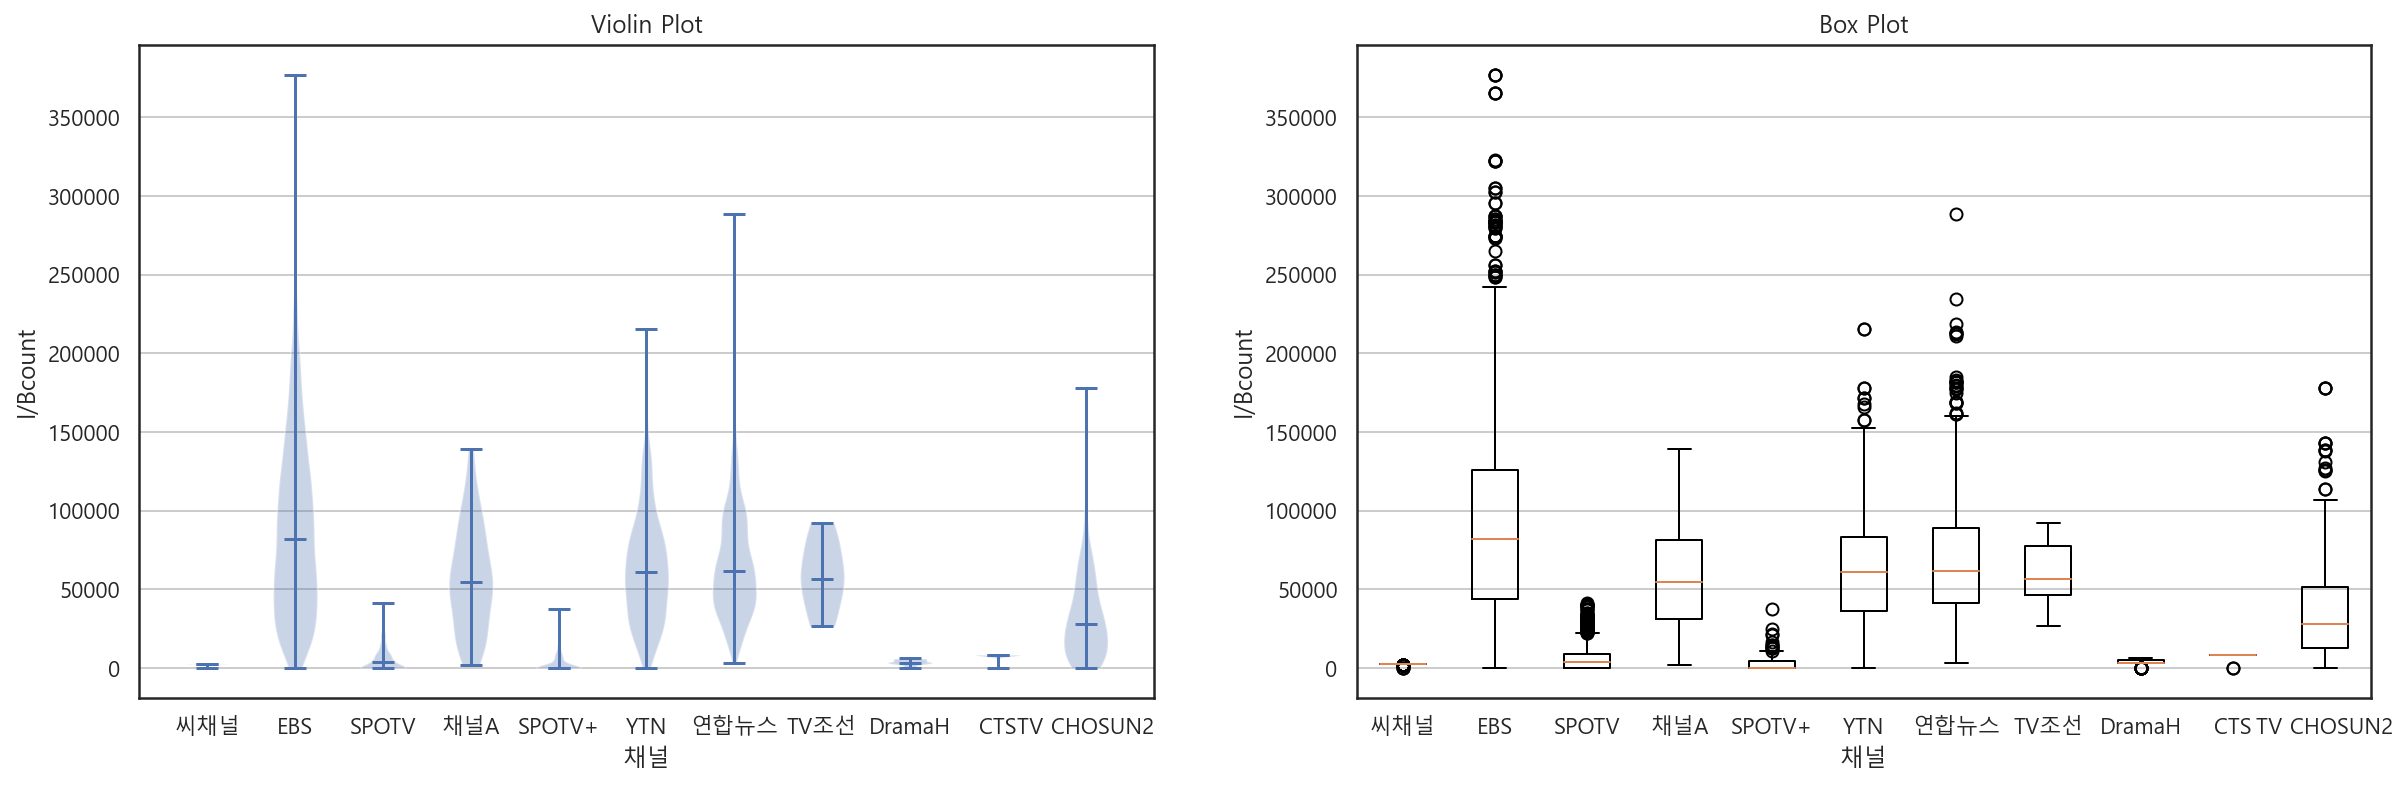

In [84]:
# plot violin plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))


# 박스플롯과 바이올린플롯 그리기
axs[0].violinplot(chartdata1,showmeans=False, showmedians=True)
axs[0].set_title('Violin Plot')

axs[1].boxplot(chartdata1)
axs[1].set_title('Box Plot')

# 수평 Grid 라인 그리기
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(chartdata1))])
    ax.set_xlabel("채널")
    ax.set_ylabel("I/Bcount")
    
# x축에 놓이는 tick지정
plt.setp(axs, xticks=[y + 1 for y in range(len(chartdata1))],xticklabels=[C_ch, EBS, SPOTV, ch_A, SPOTV_plus, YTN, NewsY, TVchosun, DramaH, CTS, TVchosun2])

plt.show()

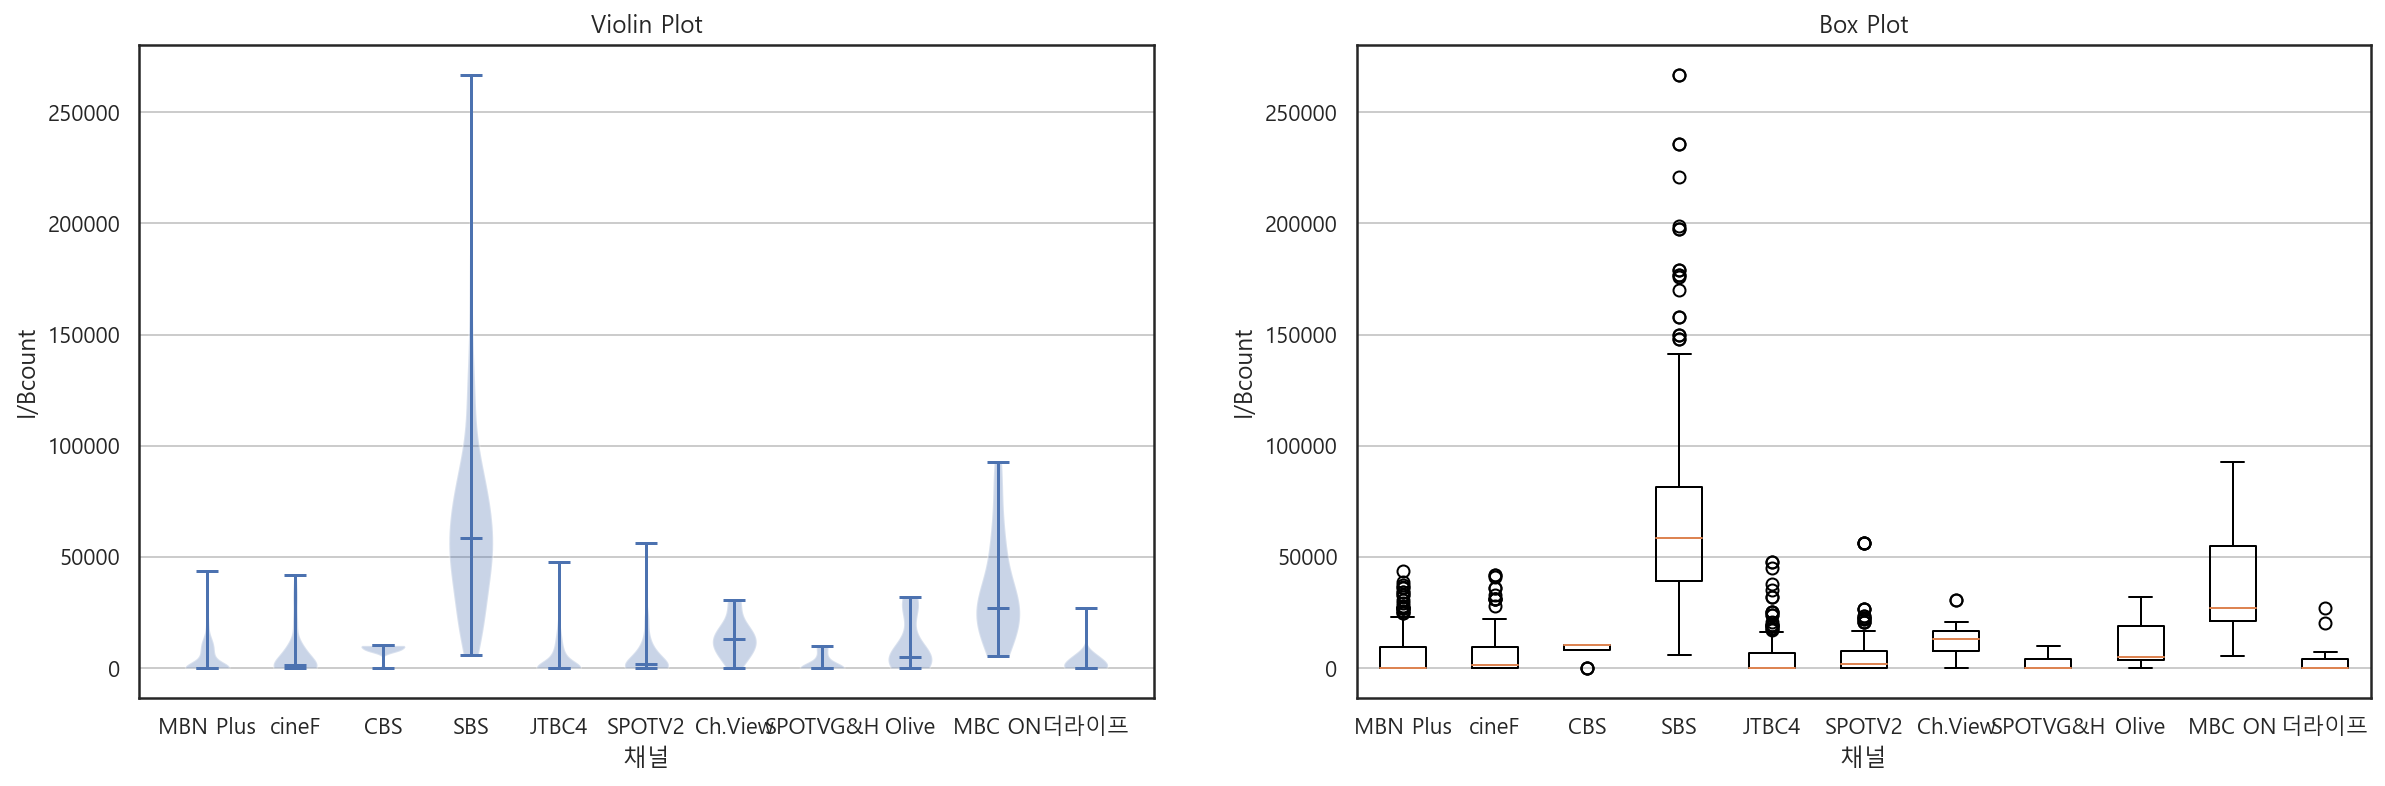

In [85]:
# plot violin plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))


# 박스플롯과 바이올린플롯 그리기
axs[0].violinplot(chartdata2,showmeans=False, showmedians=True)
axs[0].set_title('Violin Plot')

axs[1].boxplot(chartdata2)
axs[1].set_title('Box Plot')

# 수평 Grid 라인 그리기
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(chartdata2))])
    ax.set_xlabel("채널")
    ax.set_ylabel("I/Bcount")
    
# x축에 놓이는 tick지정
plt.setp(axs, xticks=[y + 1 for y in range(len(chartdata2))],xticklabels=[MBN_plus, cineF, CBS, SBS, JTBC4, SPOTV2, chView, SPOTV_gh, Olive, MBCon,theLife])

plt.show()

#### 후원광고 실적분석[컬럼별 분산 데이터]

In [87]:
# 일별합산값으로 전환
efbyday_sum = pd.pivot_table(df_result, 
                     index = ['Year','Month','Day'],
                     values = ['Net_Price','Audience','SPOT','Inbound_Calls','Reg_Donour', 'RD_Amount'],
                     aggfunc = ['sum']
                     )
efby_sum = efbyday_sum.reset_index()
cols = ['Year', 'Month','Day', 'Audience', 'Inbound_Calls', 'Net_Price', 'RD_Amount', 'Reg_Donour', 'SPOT']
efby_sum = pd.DataFrame(efby_sum.values, columns = cols)
efby_sum = efby_sum.astype({
    'Year' : str, 
    'Month': int,
    'Day' : int,
    'Audience' : int, 
    'Inbound_Calls' : int, 
    'Net_Price' : int, 
    'RD_Amount' : int, 
    'Reg_Donour' : int, 
    'SPOT' : int    
})


In [88]:
# 평가지표 컬럼추가

#Cost : VAT를 포함한 광고비
efby_sum['Cost'] = ((efby_sum['Net_Price']*1.1)/1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_sum['RD_Amount'] = (efby_sum['RD_Amount'] / 1000).astype(int)

#CV_R : Conversion Rate - 인바운드대비 정기후원전환율
efby_sum['CV_R'] = round((efby_sum['Reg_Donour'] / efby_sum['Inbound_Calls'])*100,1)

# ROI :  정기후원*12 ÷ 광고비(VAT포함)
efby_sum['ROI'] = round((efby_sum['RD_Amount']*12)/(efby_sum['Cost']), 2)

# CPR : 콜당비용, 단위천원
efby_sum['CPR'] = (efby_sum['Cost']/ efby_sum['Inbound_Calls']).astype('int')

# CPD : 후원건당비용, 단위천원
#efby_sum['CPD'] = (efby_sum['Cost']/ efby_sum['Reg_Donour']).astype('int')

# CPM : 1000명당비용, 단위천원
efby_sum['CPM'] = round((efby_sum['Cost']/ efby_sum['Audience']*1000),2)

efby_sum = efby_sum.sort_values(by=['Year'])

# 월별효율데이터
ch_eff = efby_sum[['Audience', 'SPOT', 'Inbound_Calls', 'Reg_Donour']]
ch_eff = ch_eff.reset_index(drop=True)
ch_eff = ch_eff.fillna(0)

<Figure size 720x1440 with 0 Axes>

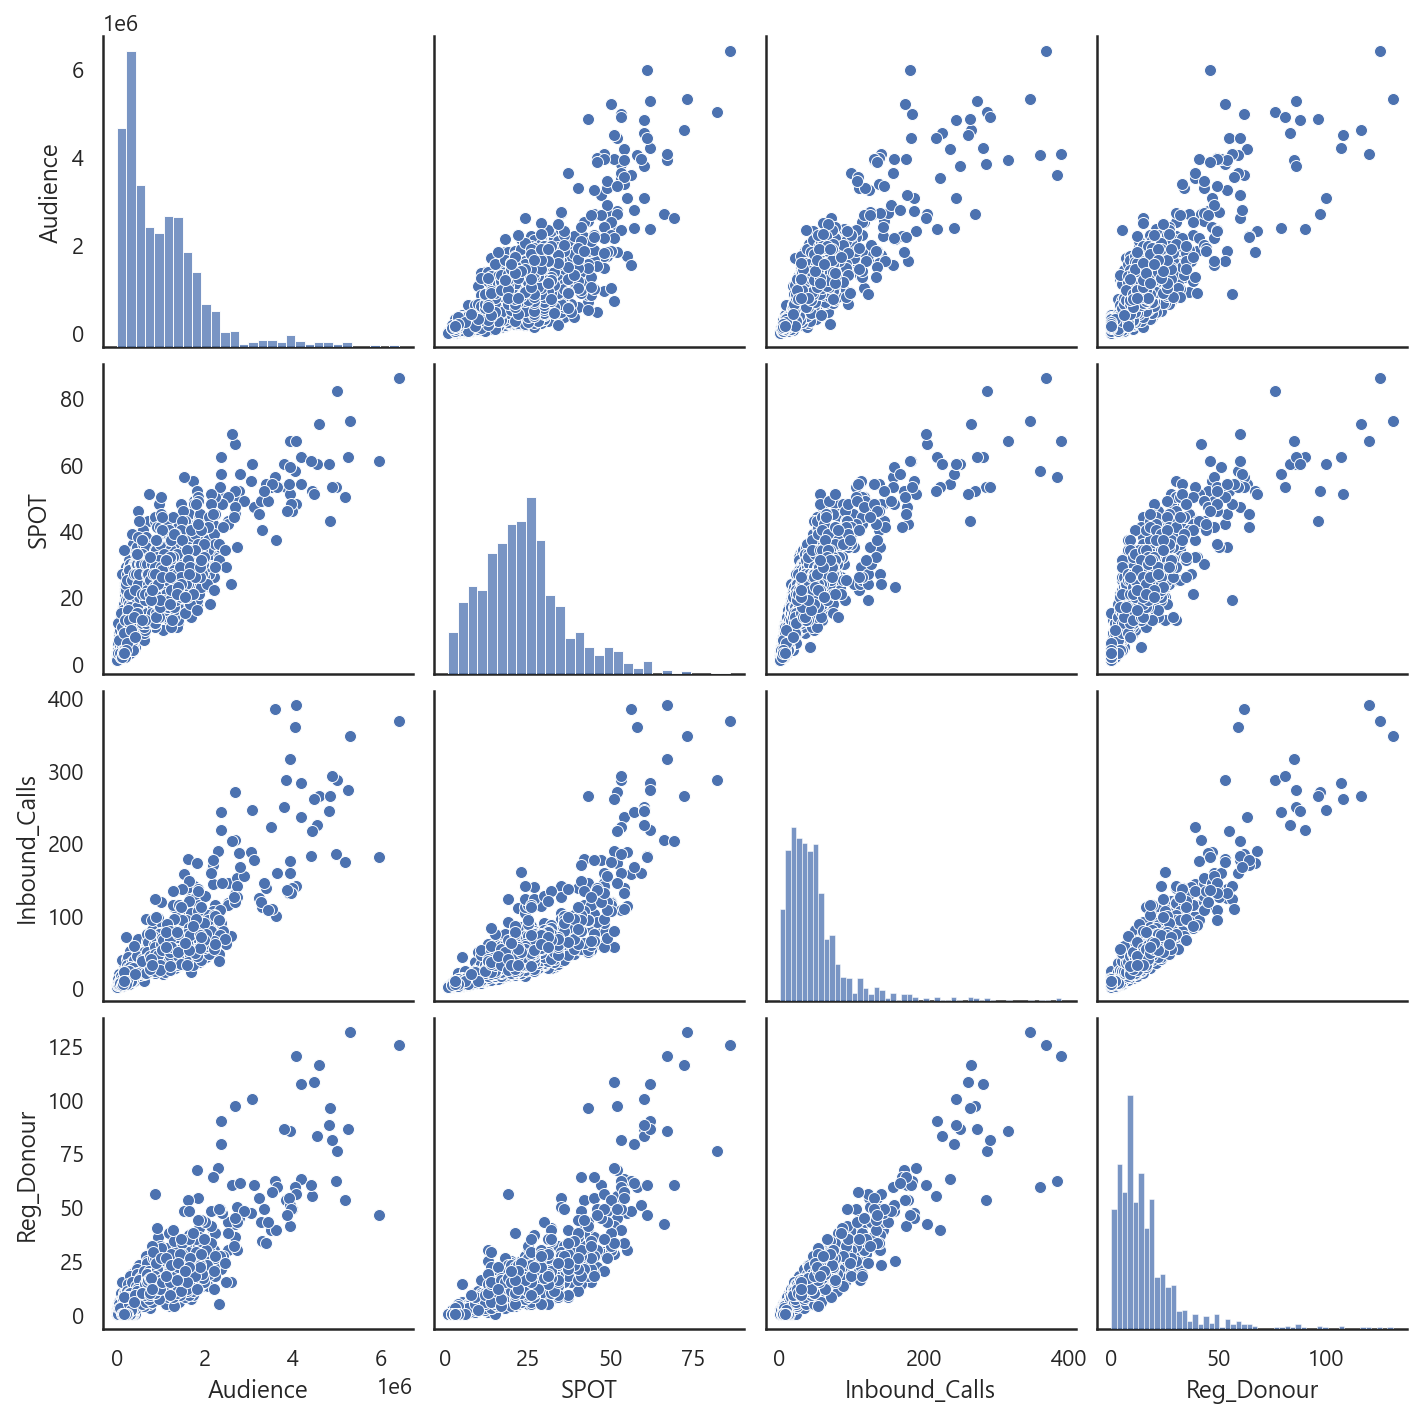

In [91]:
plt.figure(figsize=(10,20))
sns.pairplot(data=ch_eff)
plt.show()

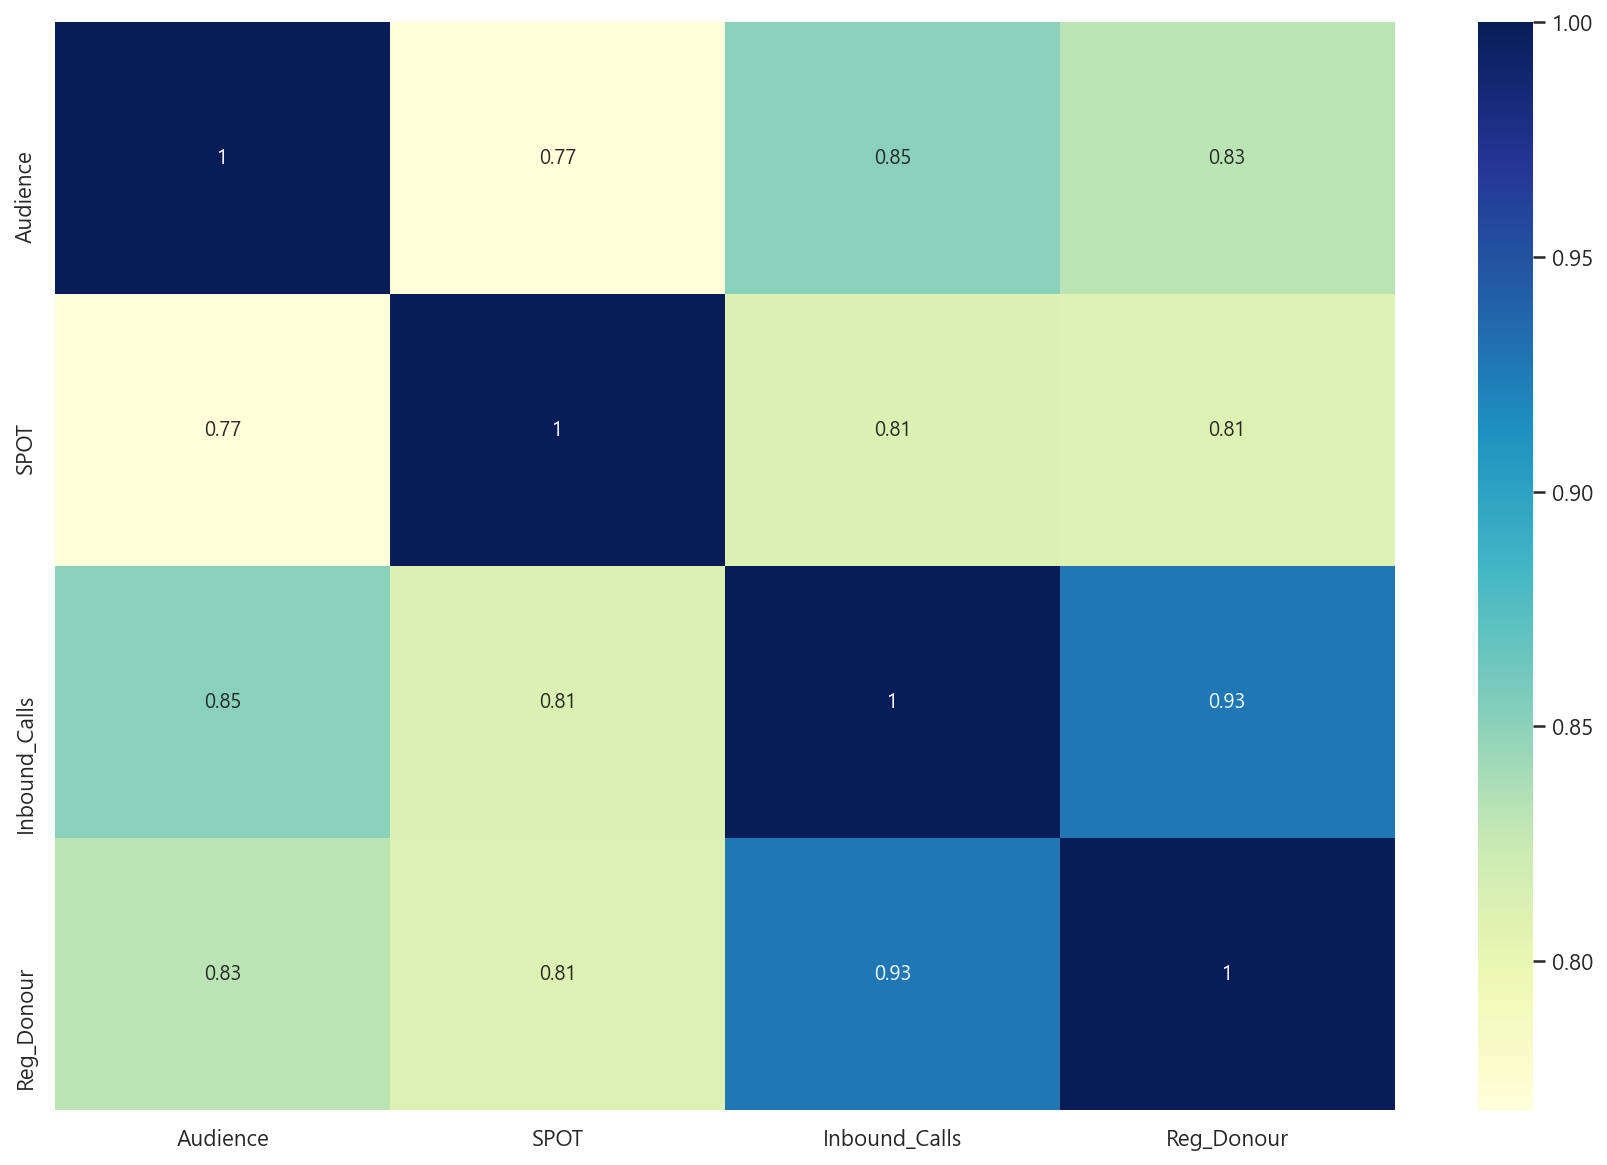

In [92]:
plt.figure(figsize=(15,10))
sns.heatmap(data=ch_eff.corr(), annot=True, cmap='YlGnBu')
plt.show()

##### 분석용 컬럼만들기

In [97]:
df_result["Daypart_Group"] = "d"
# 1. Early_Morning
df_result["Daypart_Group"][(df_result['Daypart'] == "08시대") | (df_result['Daypart'] == "09시대") | (df_result['Daypart'] == "10시대")]= "Early_morning"

# 2. Noon
df_result["Daypart_Group"][(df_result['Daypart'] == "11시대") | (df_result['Daypart'] == "12시대") | (df_result['Daypart'] == "13시대")] = "Noon"

# 3. Early_Afternoon
df_result["Daypart_Group"][(df_result['Daypart'] == "14시대") | (df_result['Daypart'] == "15시대") | (df_result['Daypart'] == "16시대")] = "Early_Afternoon"

# 4. Late_Afternoon
df_result["Daypart_Group"][(df_result['Daypart'] == "17시대") | (df_result['Daypart'] == "18시대") | (df_result['Daypart'] == "19시대")]="Late_Afternoon"

# 5. Midnight
df_result["Daypart_Group"][(df_result['Daypart'] == "20시대") | (df_result['Daypart'] == "21시대") | (df_result['Daypart'] == "22시대")]="Mid_night"

In [110]:
col_default = pd.pivot_table(df_result, 
                     index = 'Date',
                     values = ['Net_Price','Audience','SPOT','Inbound_Calls','Reg_Donour', 'RD_Amount'],
                     aggfunc = ['sum']
                     )
col_default = col_default.astype("int")
col_def = col_default["sum"].reset_index()
col_def.head()


# CPM, Rating, ROI 컬럼 추가
col_def["CPM"] = round(col_def["Net_Price"]/col_def["Audience"]*1000,0)
col_def["Rate"] = round(col_def["Audience"]/col_def["SPOT"],0)
col_def["ROI"] = round(col_def["RD_Amount"]*12/col_def["Net_Price"],1)

# 집행된채널의갯수 컬럼
col2 = df_result[["Date", "Channel", "SPOT"]].groupby(by=['Date','Channel'], as_index=False).count()
col2['Count'] = col2["SPOT"]/col2["SPOT"]
col_ch_count = col2.groupby(by=['Date'], as_index=False).count()
col_ch_count = col_ch_count[["Date", "Channel"]]

# 집행된소재의갯수 컬럼
col3 = df_result[["Date", "Creative", "SPOT"]].groupby(by=['Date','Creative'], as_index=False).count()
col3['Count'] = col3["SPOT"]/col2["SPOT"]
col_cr_count = col3.groupby(by=['Date'], as_index=False).count()
col_cr_count = col_cr_count[["Date", "Creative"]]

# 집행된채널, 소재의 갯수 컬럼 추가
col_def["Ch_count"] = col_ch_count["Channel"]
col_def["Cr_count"] = col_cr_count["Creative"]


# 국내소재와 해외소재비중 컬럼

col3 = pd.pivot_table(df_result, 
                     index = 'Date',
                     columns = 'Category',
                     values = 'Audience',
                     aggfunc = ['sum']
                     )

col3_cate = col3["sum"].reset_index()
col_def["Cate_Ratio_Domestic"] = round(col3_cate["국내"]/(col3_cate["국내"]+col3_cate["해외"]),2)
col_def["Cate_Ratio_Global"] = round(col3_cate["해외"]/(col3_cate["국내"]+col3_cate["해외"]),2)




# 연령별시청비중, Reach 등 컬럼추가
rating = pd.read_excel("./Datas/TV_gra.xlsx")
df_fn = pd.merge(col_def, rating, on='Date', how='inner')

rating2 = pd.read_excel("./Datas/TV_gra_age.xlsx")
df_fn2 = pd.merge(df_fn, rating2, on='Date', how='inner')

df_lm = df_fn2[['Net_Price','SPOT', 'Audience', 'CPM', 'Rate', 'Ch_count', 'Cr_count','Cate_Ratio_Domestic', 'Cate_Ratio_Global', 
               'In_Rating', 'In_Reach1+', 'In_Reach3+', 'In_Reach', 'F40_Reach', 'F50_Reach', 'F60_Reach','M60_Reach', 'M50_Reach',
               'M40_Reach', 'F40_Ratio', 'F50_Ratio', 'F60_Ratio', 'M60_Ratio', 'M50_Ratio', 'M40_Ratio', 'F40_Aud','F50_Aud',
                'F60_Aud', 'M60_Aud', 'M50_Aud', 'M40_Aud',
                'Inbound_Calls', 'Reg_Donour', 'RD_Amount']]

## 3. 회귀분석모델

#### 회귀분석을 위한 데이터프레임 - 컬럼정보

In [114]:
df_lm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Net_Price            1051 non-null   int32  
 1   SPOT                 1051 non-null   int32  
 2   Audience             1051 non-null   int32  
 3   CPM                  1049 non-null   float64
 4   Rate                 1051 non-null   float64
 5   Ch_count             1051 non-null   int64  
 6   Cr_count             1051 non-null   int64  
 7   Cate_Ratio_Domestic  702 non-null    float64
 8   Cate_Ratio_Global    702 non-null    float64
 9   In_Rating            1051 non-null   float64
 10  In_Reach1+           1051 non-null   float64
 11  In_Reach3+           1051 non-null   float64
 12  In_Reach             1051 non-null   int64  
 13  F40_Reach            1051 non-null   int64  
 14  F50_Reach            1051 non-null   int64  
 15  F60_Reach            1051 non-null   i

#### 회귀분석을 위한 데이터프레임

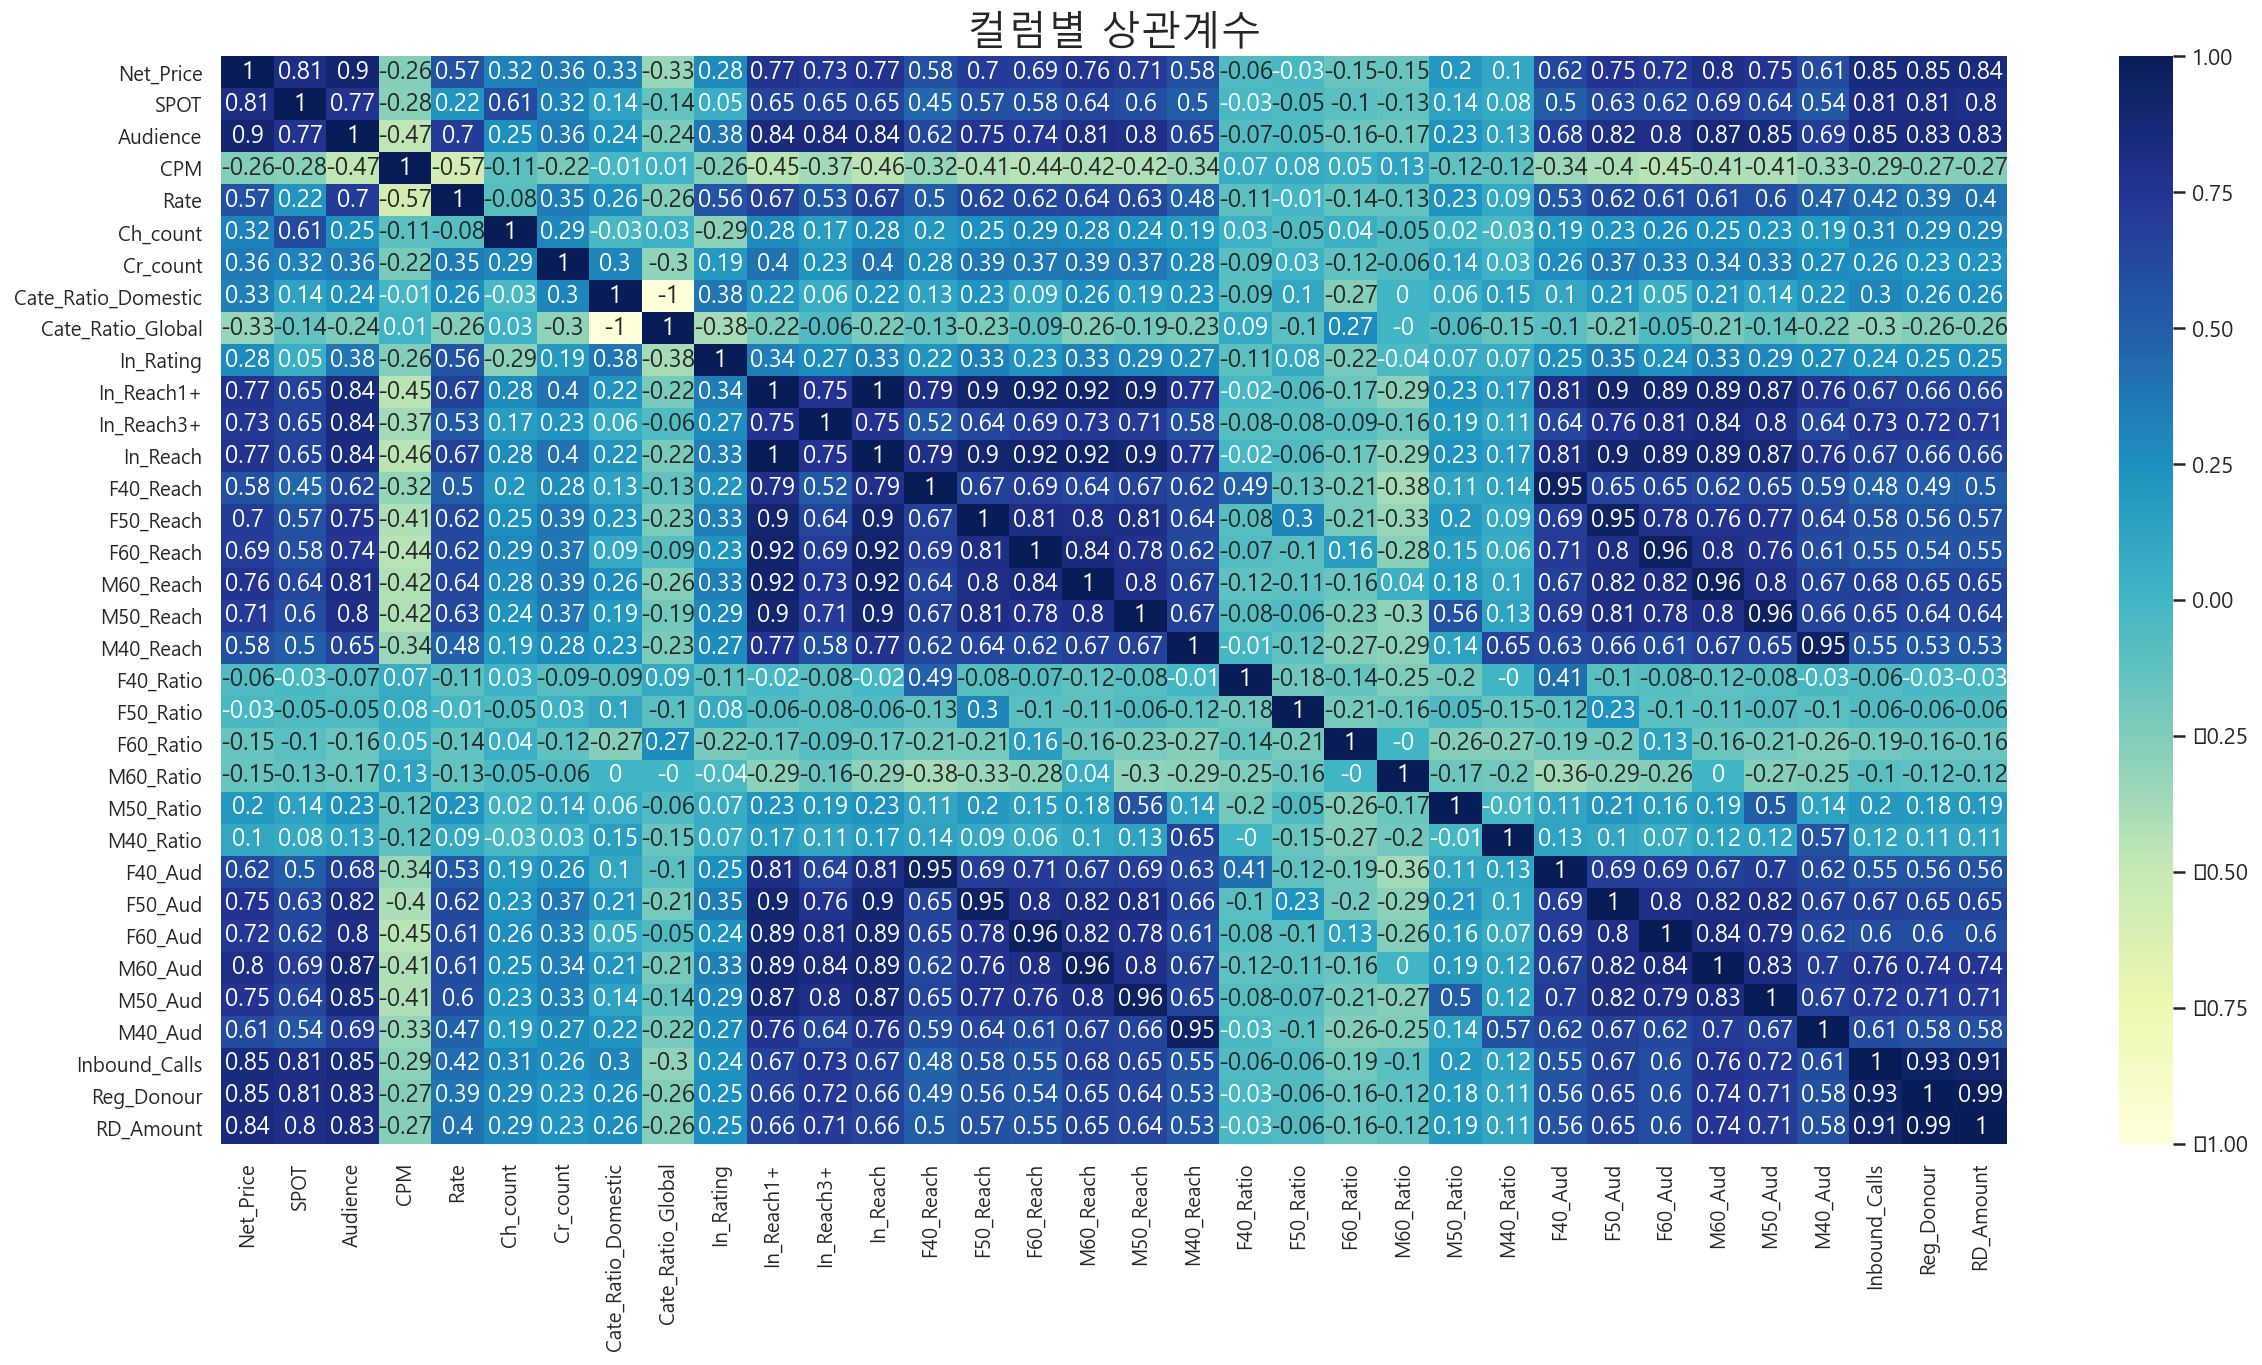

In [115]:
plt.figure(figsize=(20,10))
plt.title("컬럼별 상관계수", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(data=round(df_lm.corr(),2), annot=True, cmap="YlGnBu", annot_kws={"size": 12})
plt.show()

### A. 광고량과 인바운드콜에 대한 회귀분석 : 단일회귀

In [152]:
df_lm = df_lm[df_lm['Inbound_Calls'] < 100]
df_lm2 = df_lm[['Audience', 'Inbound_Calls']]

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

X1 = df_lm2.drop('Inbound_Calls', axis=1)
y1 = df_lm2['Inbound_Calls']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=13)

In [154]:
# 모델 fit
## Lr
lr_reg1 = LinearRegression()
lr_reg1.fit(X1_train, y1_train)

LinearRegression()

In [155]:
# OLS
import statsmodels.api as sm

lm = sm.OLS(y1_train, X1_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Inbound_Calls   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              4439.
Date:                Fri, 21 May 2021   Prob (F-statistic):                   1.89e-307
Time:                        17:01:06   Log-Likelihood:                         -2999.0
No. Observations:                 710   AIC:                                      6000.
Df Residuals:                     709   BIC:                                      6005.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Audience    4.091e-05   6.14e-07     66.628      0.000    3.97e-05    4.21e-05
==============================================================================
Omnibus:                       27.401   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.332
Skew:                          -0.155   Prob(JB):                     1.77e-14
Kurtosis:                       4.430   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

pred_tr1 = lr_reg1.predict(X1_train)
pred_test1 = lr_reg1.predict(X1_test)
rmse_tr1 = (np.sqrt(mean_squared_error(y1_train, pred_tr1)))
rmse_test1 = (np.sqrt(mean_squared_error(y1_test, pred_test1)))

print('RMSE of Train Data : ', rmse_tr1.astype(int))
print('RMSE of Test Datea : ', rmse_test1.astype(int))

RMSE of Train Data :  13
RMSE of Test Datea :  15


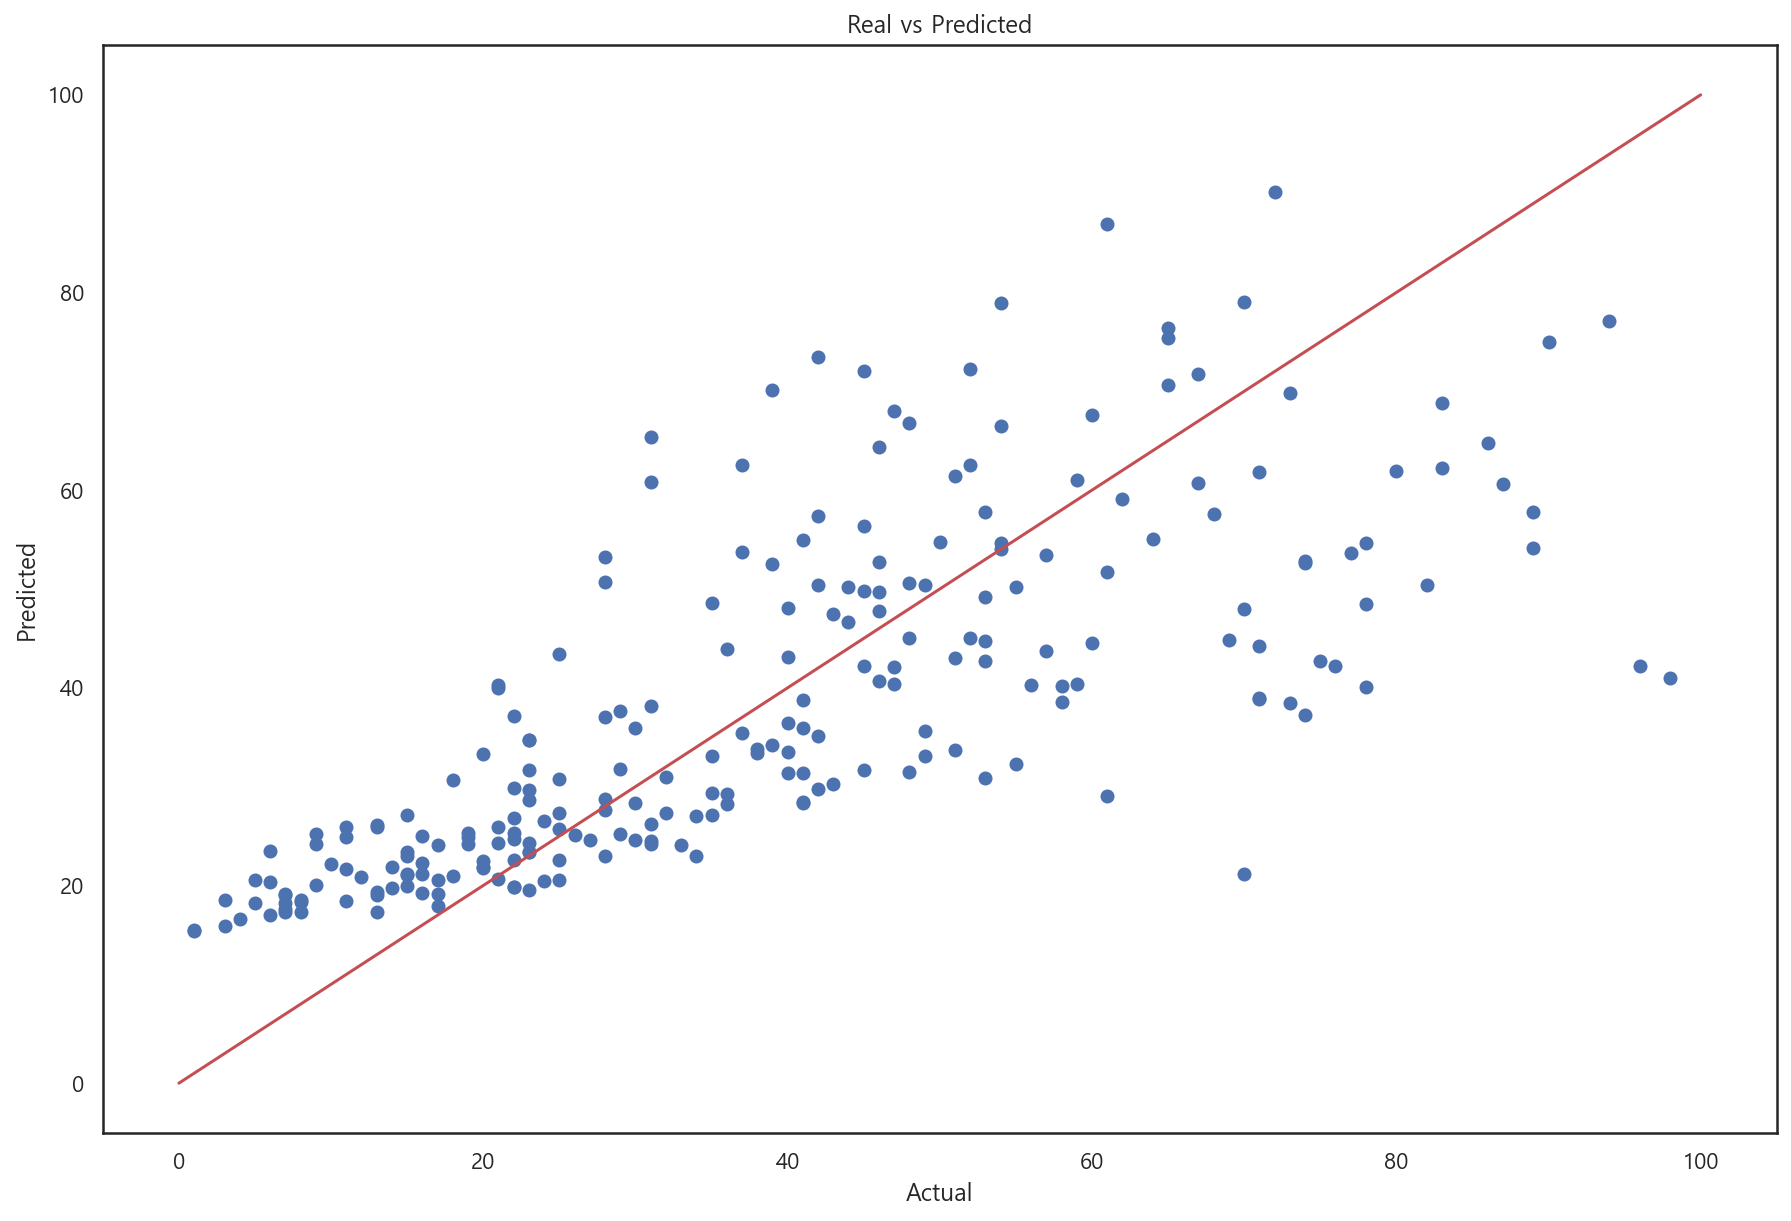

In [206]:
# Atual vs Predict
plt.figure(figsize=(15,10))
plt.scatter(y1_test, pred_test1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Real vs Predicted")
plt.plot([0,100], [0,100], 'r')
plt.show()

### B. 광고량과 인바운드콜에 대한 회귀분석 : 다중선형회귀

In [159]:
df_lm3 = df_lm[['Audience', 'SPOT','In_Reach1+','In_Reach3+','M50_Reach', 'M40_Reach','M60_Aud','Inbound_Calls']]

In [160]:
X2 = df_lm3.drop('Inbound_Calls', axis=1)
y2 = df_lm3['Inbound_Calls']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=13)

In [161]:
# 모델 fit
## Lr
lr_reg2 = LinearRegression()
lr_reg2.fit(X2_train, y2_train)

LinearRegression()

In [162]:
#OLS
import statsmodels.api as sm

lm = sm.OLS(y2_train, X2_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Inbound_Calls   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              1843.
Date:                Fri, 21 May 2021   Prob (F-statistic):                        0.00
Time:                        17:01:27   Log-Likelihood:                         -2651.1
No. Observations:                 710   AIC:                                      5316.
Df Residuals:                     703   BIC:                                      5348.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Audience    1.197e-05   1.28e-06      9.359      0.000    9.46e-06    1.45e-05
SPOT           0.9939      0.040     24.826      0.000       0.915       1.072
In_Reach1+    -4.2890      1.144     -3.750      0.000      -6.535      -2.043
In_Reach3+   -12.8623      4.190     -3.070      0.002     -21.088      -4.636
M50_Reach      0.0001   2.16e-05      5.137      0.000    6.87e-05       0.000
M40_Reach   8.351e-05   2.58e-05      3.236      0.001    3.28e-05       0.000
M60_Aud     7.529e-05   1.17e-05      6.448      0.000    5.24e-05    9.82e-05
==============================================================================
Omnibus:                      164.860   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              468.237
Skew:                           1.144   Prob(JB):                    2.11e-102
Kurtosis:                       6.255   Cond. No.                     1.12e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.12e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [163]:
# RMSE
pred_tr2 = lr_reg2.predict(X2_train)
pred_test2 = lr_reg2.predict(X2_test)
rmse_tr2 = (np.sqrt(mean_squared_error(y2_train, pred_tr2)))
rmse_test2 = (np.sqrt(mean_squared_error(y2_test, pred_test2)))


print('RMSE of Train Data : ', rmse_tr2.astype(int))
print('RMSE of Test Datea : ', rmse_test2.astype(int))

RMSE of Train Data :  10
RMSE of Test Datea :  10


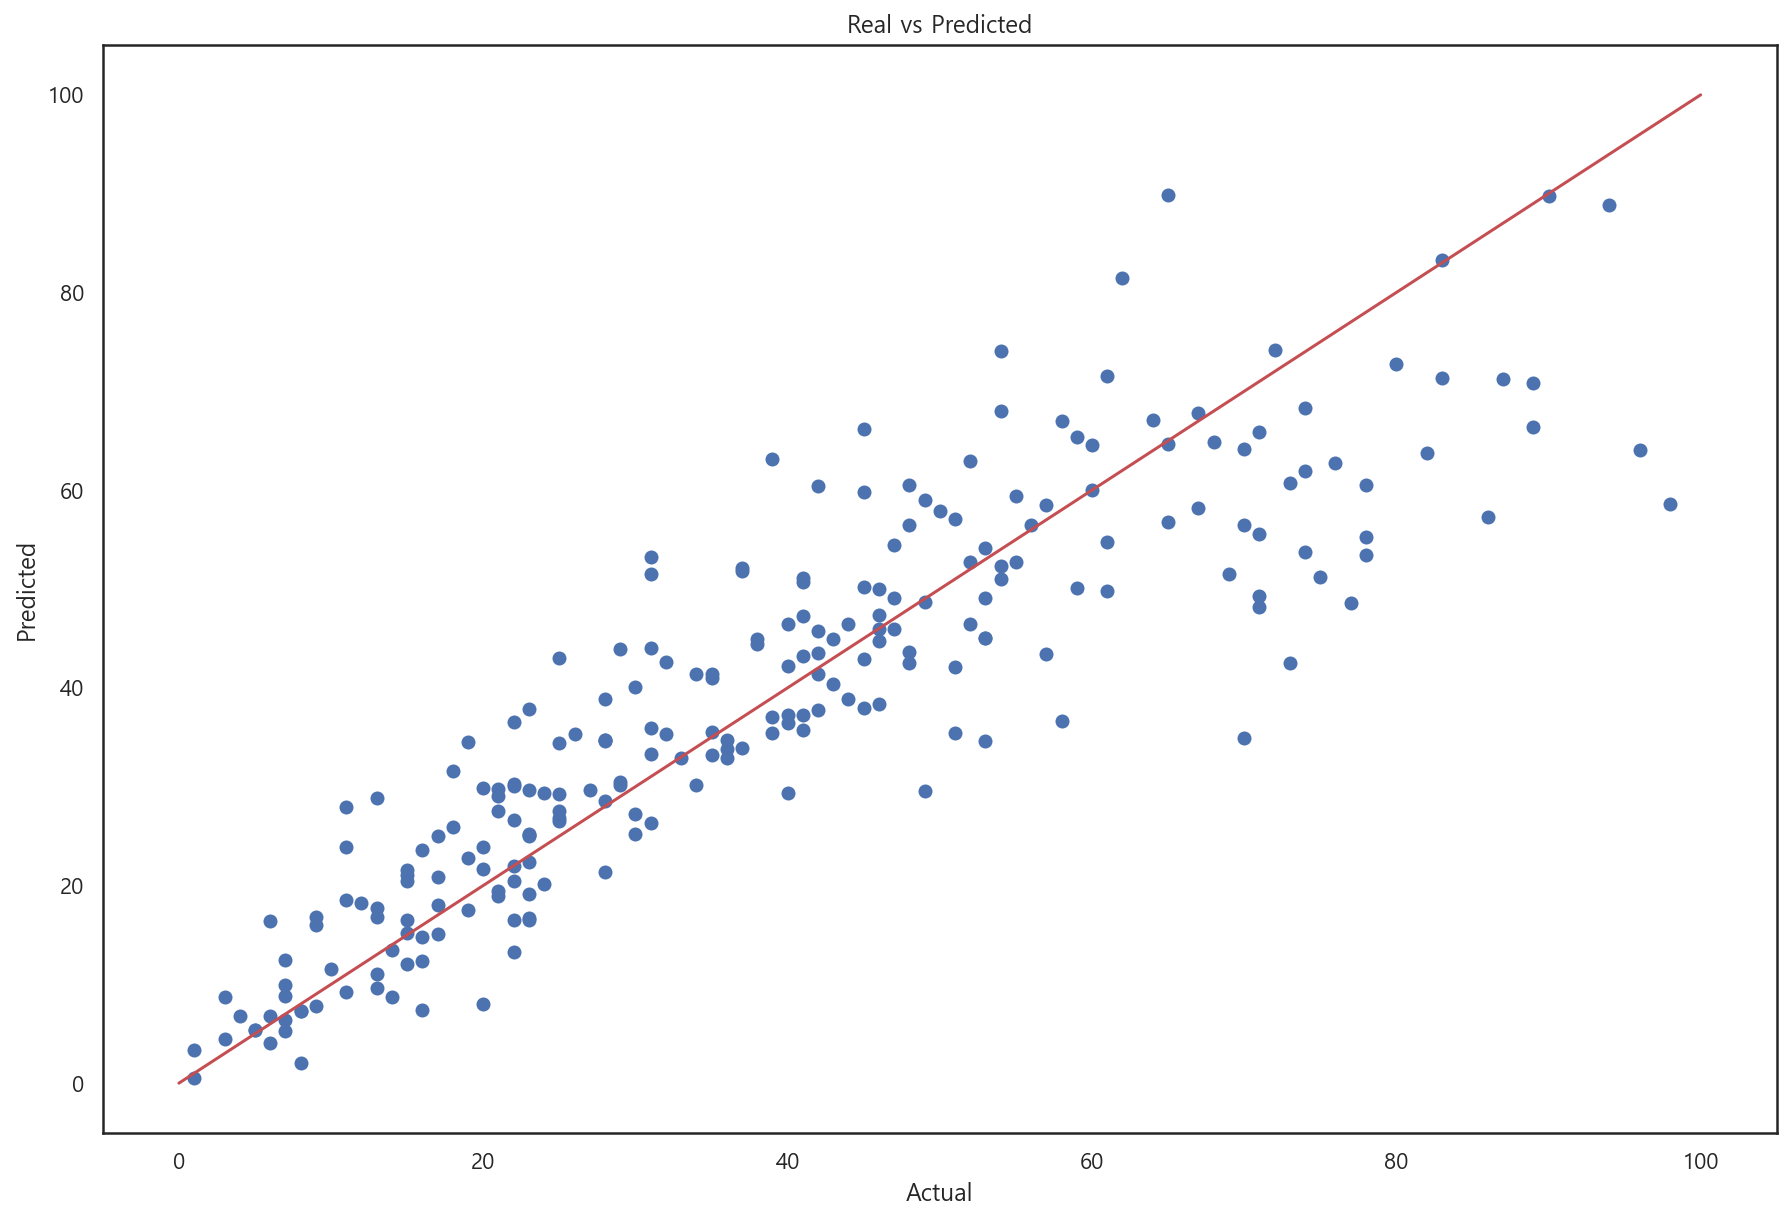

In [207]:
# Actual vs Predcit
plt.figure(figsize=(15,10))
plt.scatter(y2_test, pred_test2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Real vs Predicted")
plt.plot([0,100], [0,100], 'r')
plt.show()

### C. 인바운드콜과 후원건수에 대한 선형회귀 : 단일

In [165]:
df_lm4 = df_lm[['Inbound_Calls', 'Reg_Donour']]

In [166]:
X3 = df_lm4.drop('Reg_Donour', axis=1)
y3 = df_lm4['Reg_Donour']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=13)

In [167]:
# 모델 fit
## Lr
lr_reg3 = LinearRegression()
lr_reg3.fit(X3_train, y3_train)

LinearRegression()

In [168]:
# OLS
import statsmodels.api as sm

lm = sm.OLS(y3_train, X3_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Reg_Donour   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              8066.
Date:                Fri, 21 May 2021   Prob (F-statistic):                        0.00
Time:                        17:01:40   Log-Likelihood:                         -2027.3
No. Observations:                 710   AIC:                                      4057.
Df Residuals:                     709   BIC:                                      4061.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Inbound_Calls     0.3185      0.004     89.809      0.000       0.312       0.325
==============================================================================
Omnibus:                       29.303   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.966
Skew:                          -0.054   Prob(JB):                     4.32e-18
Kurtosis:                       4.641   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
# RSME
pred_tr3 = lr_reg3.predict(X3_train)
pred_test3 = lr_reg3.predict(X3_test)
rmse_tr3 = (np.sqrt(mean_squared_error(y3_train, pred_tr3)))
rmse_test3 = (np.sqrt(mean_squared_error(y3_test, pred_test3)))


print('RMSE of Train Data : ', rmse_tr3.astype(int))
print('RMSE of Test Datea : ', rmse_test3.astype(int))

RMSE of Train Data :  4
RMSE of Test Datea :  4


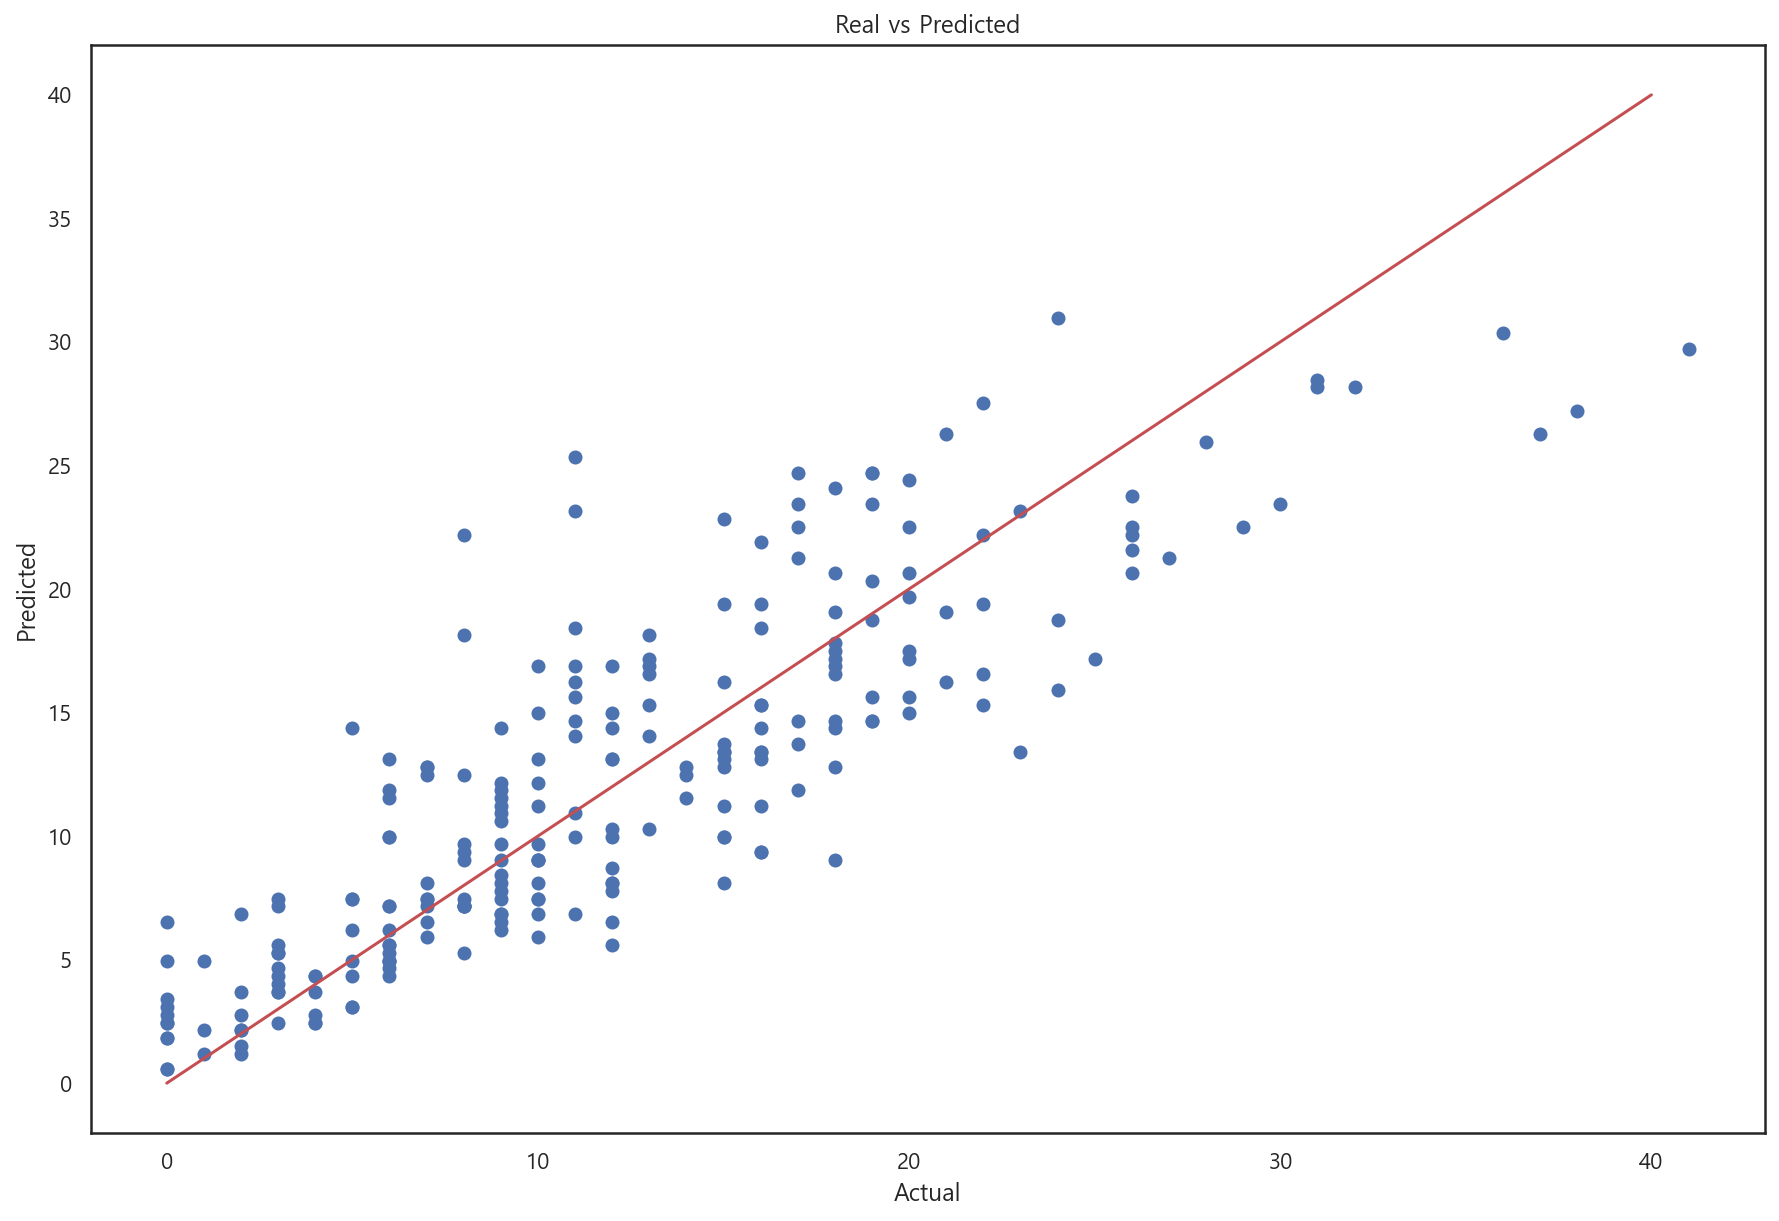

In [208]:
# Actual vs Predict
plt.figure(figsize=(15,10))
plt.scatter(y3_test, pred_test3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Real vs Predicted")
plt.plot([0,40], [0,40], 'r')
plt.show()

## 4.회귀모델 예측값으로 광고예산 대비 예상ROI, 예상후원금 Curve

##### 실제 보험광고 4월1일~2일까지 일별 광고집행 케이스적용하여 후원전화, 콜수 예측

In [187]:
lm_test = pd.read_excel("./Datas/lm_test.xlsx")
lm_test.fillna(0)
lm =  lm_test[['Audience', 'SPOT', 'In_Reach1+',
       'In_Reach3+', 'M50_Reach', 'M40_Reach', 'M60_Aud']]

In [188]:
# 콜수예측
predict1 = lr_reg2.predict(lm)
predict1 = pd.DataFrame(predict1)

In [189]:
# 후원건수예측
predict2 = lr_reg3.predict(predict1)
predict2 = pd.DataFrame(predict2)

In [196]:
# 실제 케이스 자료에 후원전화 및 건수 예측값 추가
lm_test['Pre_Inbound_Calls'] = predict1.values
lm_test['Pre_Reg_Donour'] = predict2.values
lm_test = lm_test.fillna(0)
lm_test = lm_test.drop(["Advertiser","Product","Date"], axis=1)

In [197]:
lm_test.tail(5)

Audience  SPOT  In_Reach1+  In_Reach3+  M50_Reach  M40_Reach  M60_Aud  \
1418   3091586    87         7.1         1.5     167423     102342   321131   
1419   4012698    83        10.5         1.5     353299     275699   443548   
1420   3951153    73        12.6         0.7     406925     256491   423295   
1421   1128961    67         3.8         0.2      81103      86638    79206   
1422    785948     4         2.9         0.0      89036      68353    54988   

      chgroup_TTV  chgroup_GTV  chgroup_CATV  Pre_Inbound_Calls  \
1418     536415.0          0.0     2555171.0         127.940848   
1419    1687534.0          0.0     2325164.0         165.467066   
1420    2496389.0          0.0     1454765.0         162.385094   
1421     371841.0          0.0      757119.0          86.765270   
1422     785948.0          0.0           0.0          19.640052   

      Pre_Reg_Donour  
1418       40.377803  
1419       52.147488  
1420       51.180862  
1421       27.463536  
1422        6.410451

In [564]:
# lm_test.to_excel("./Datas/lm_result.xlsx")

In [198]:
# 실제케이스 통한 예측자료 불러오기
lm_result = pd.read_excel("./Datas/lm_result.xlsx")
lm_result.columns

Index(['Advertiser', 'Product', 'Date', 'Audience', 'SPOT', 'In_Reach1+',
       'In_Reach3+', 'M50_Reach', 'M40_Reach', 'M60_Aud', 'chgroup_TTV',
       'chgroup_GTV', 'chgroup_CATV', 'Pre_Inbound_Calls', 'Pre_Reg_Donour',
       'Cost', 'RD_Amount', 'ROI'],
      dtype='object')

## 4. 예측모델적용 : 예산대비 예상 ROI 및 후원금 예측 Curve

In [199]:
# 그래프 그리기위해 컬럼가공
lm_result_vi = lm_result[['Cost', 'Pre_Inbound_Calls', 'Pre_Reg_Donour','RD_Amount', 'ROI']]

In [200]:
lm_result_vi['ROI'] = round(lm_result_vi["ROI"],2)

In [201]:
lm_result_vi['Cost2'] = lm_result_vi['Cost']/1000

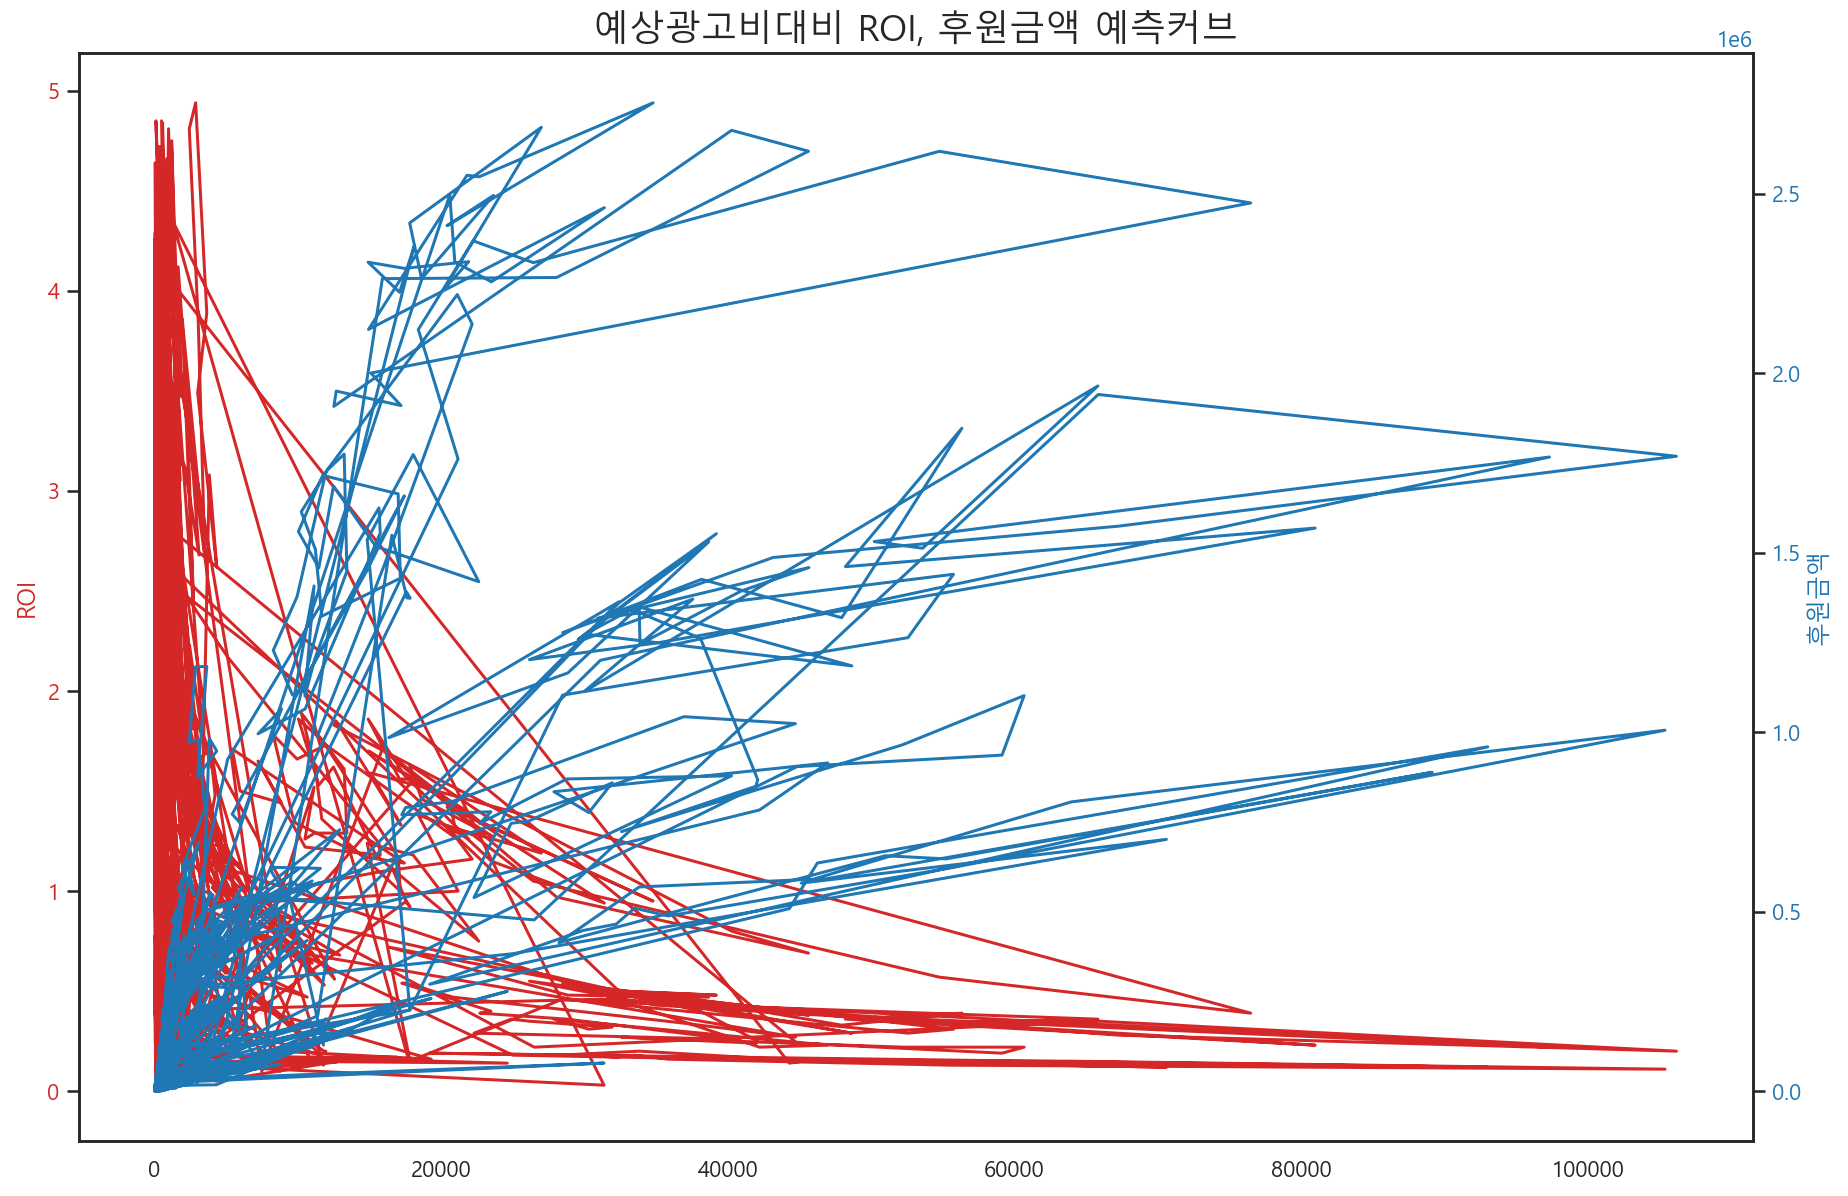

In [212]:
fig, ax1 = plt.subplots(figsize=(15,10))

xrange = range(len(lm_result_vi))



ax1.set_title('예상광고비대비 ROI, 후원금액 예측커브', fontsize=18)
color = 'tab:red'
ax1.set_ylabel('ROI', color=color)
ax1.plot(lm_result_vi.loc[:,['Cost2']], lm_result_vi.loc[:,['ROI']], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('후원금액', color=color)
ax2.plot(lm_result_vi.loc[:,['Cost2']], lm_result_vi.loc[:,['RD_Amount']], color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

#### 결론
- 광고량으로 인바운드 콜을 예측하기 위해 광고노출량(시청자수)외 커버리지(Reach), 연령별 변수 추가 필요
- 50대, 60대 남성의 도달자수가 예측력을 높이는 데 중요한 특성
- Reach 1+와 Reach3+ 등 단순노출 외 광고의 커버리지를 반영 -> 채널조합에 따른 변수를 포함
- 모델을 적용하여 예산(일평균) 대비 예상 ROI와 예상 후원금 시뮬레이션
    - 예산에 따른 예상후원금은 3개의 군집으로 시뮬레이션되는 것으로 보임
    - 채널(지상파그룹, 유료채널, 종편그룹)의 비중에 따라 시뮬레이션 커브가 달라지는 것으로 판단됨
- 추후 전체채널에 대해서 분류모델을 적용하여 적정채널 조합을 제시하는 모델로 발전 가능성 높음

## 5. 향후개선 사항 및 과제
 - 광고소재, 시간대 등 정성적인 특성을 정량화하여 추가 특성을 만들어 모델 정교화
 - 적정채널 믹스를 제공하기 위한 분류 학습 접목